# IMPORT DES LIBRAIRIES

In [1]:
import kagglehub
from os import listdir
from os.path import join, isfile
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import figure
from matplotlib.backends.backend_pdf import PdfPages
import plotly.express as px
import plotly.subplots as psp
import numpy as np
from numpy import number
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind, pearsonr
import statistics
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multitest import multipletests

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EXTRACT

In [3]:
# Download latest version
path = kagglehub.dataset_download("mirzayasirabdullah07/smartwatch-sleep-tracking-dataset-20182025")

Using Colab cache for faster access to the 'smartwatch-sleep-tracking-dataset-20182025' dataset.


In [4]:
# Initialisation du dataset
file_name = [f for f in listdir(path) if isfile(join(path, f))]
df_sleep = pd.read_csv(f"{path}/{file_name[0]}")
print(f"Le dataset df_sleep contient {df_sleep.shape[0]} lignes et {df_sleep.shape[1]} colonnes.")


Le dataset df_sleep contient 20000 lignes et 45 colonnes.


# TRANSFORM

In [5]:
# Cast des colonnes temporelles
for x in df_sleep[["date_recorded","sleep_start_timestamp","sleep_end_timestamp","created_at"]].columns :
  df_sleep[x] = pd.to_datetime(df_sleep[x], errors="coerce")

In [6]:
# CREATION DE COLONNES CALCULÉES

df_sleep["movement_count_by_min"] = df_sleep["movement_count"]/df_sleep["duration_minutes"]
df_sleep["IMC"] = df_sleep["weight_kg"]/((df_sleep["height_cm"]/100)**2)
df_sleep["alcohol_by_IMC"] = df_sleep["alcohol_units"]/df_sleep["IMC"]*100
df_sleep["snore_events_by_hour"] = df_sleep["snore_events"]/(df_sleep["duration_minutes"]/60)
df_sleep["record_count"]=df_sleep.groupby("user_id")["user_id"].transform("count")

In [7]:
# Passage de la valeur catégorielle "genre" en float64 avec drop des "other"
df_sleep = df_sleep.loc[df_sleep["gender"]!="other"].copy()
df_sleep["gender"] = df_sleep["gender"].replace(["male","female"],[1,0])

# Transformation des heures de coucher avec heure min à 17h devient 1
df_sleep["start_hour"]=(df_sleep["sleep_start_timestamp"].dt.hour + 32 )% 24
df_sleep["start_hour_name"] = df_sleep["sleep_start_timestamp"].dt.hour.astype(str)+"h"

# Transformation des heures de lever avec heure min à 23h devient 1
df_sleep["end_hour"]=(df_sleep["sleep_end_timestamp"].dt.hour + 26 )% 24
df_sleep["end_hour_name"] = df_sleep["sleep_end_timestamp"].dt.hour.astype(str)+"h"

/tmp/ipython-input-1650332985.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sleep["gender"] = df_sleep["gender"].replace(["male","female"],[1,0])


In [8]:
# Drop des IMC inférieurs à 15 et supérieurs à 40
# df_sleep = df_sleep.loc[(df_sleep["IMC"] > 15) & (df_sleep["IMC"]< 40)].copy()

In [9]:
# PASSAGE DU APNEA_RISK_SCORE
df_sleep["new_apnea_risk_score"] = df_sleep["apnea_risk_score"]*2

# CRÉATION D'UNE SECONDE COLONNE CATÉGORIELLES POUR L'IMC
IMC2_bins = [0,16.5,18.5,25,30,35,40,100]
IMC2_labels = ["Dénutrition","Maigreur","Corpulence normale","Surpoids","Obésité modérée","Obésité sévère","Obésité morbide"]
df_sleep["IMC_cat"] = pd.cut(df_sleep["IMC"], bins=IMC2_bins, labels=IMC2_labels, include_lowest=True)

# CRÉATION D'UNE COLONNE CATÉGORIELLE POUR L'ÂGE
age_bins = [18,30,40,50,60,70,100]
age_labels = ["18-29 ans","30-39 ans","40-49 ans","50-59 ans","60-69 ans","70 ans et +"]
df_sleep["age_cat"] = pd.cut(df_sleep["age"], bins=age_bins, labels=age_labels, include_lowest=True)

# CRÉATION D'UNE SECONDE COLONNE CATÉGORIELLE POUR L'ÂGE
age2_bins = [18,50,100]
age2_labels = ["Moins de 50 ans","Plus de 50 ans"]
df_sleep["age_cat_50"] = pd.cut(df_sleep["age"], bins=age2_bins, labels=age2_labels, include_lowest=True)

# CRÉATION DE COLONNES CATÉGORIELLES POUR L'HEURE DE COUCHER ET DE LEVER
start_hour_bins = [1,4,5,6,8,100]
start_hour_labels = ["Avant 20h","20h-21h","21h-22h","22h-minuit","Après minuit"]
df_sleep["start_hour_cat"] = pd.cut(df_sleep["start_hour"], bins=start_hour_bins, labels=start_hour_labels, include_lowest=True)

end_hour_bins = [1,6,7,8,9,11,100]
end_hour_labels = ["Avant 4h","4h-5h","5h-6h","6h-7h","7h-9h","Après 9h"]
df_sleep["end_hour_cat"] = pd.cut(df_sleep["end_hour"], bins=end_hour_bins, labels=end_hour_labels, include_lowest=True)

# CRÉATION D'UNE COLONNE CATÉGORIELLE POUR L'ALCOHOL BY IMC
alcohol_by_IMC_bins = [-1,0,5,10,100]
alcohol_by_IMC_labels = ["0","De 0 à 5","De 5 à 10","Supérieur à 10"]
df_sleep["alcohol_by_IMC_cat"] = pd.cut(df_sleep["alcohol_by_IMC"], bins=alcohol_by_IMC_bins, labels=alcohol_by_IMC_labels, include_lowest=True)

# CRÉATION D'UNE COLONNE CATÉGORIELLE POUR LE SLEEP SCORE
sleep_score_bins = [31,45,55,60,65,100]
sleep_score_labels = ["Inférieur à 45","De 45 à 55","De 55 à 60","De 60 à 65","Supérieur à 65"]
df_sleep["sleep_score_cat"] = pd.cut(df_sleep["sleep_score"], bins=sleep_score_bins, labels=sleep_score_labels, include_lowest=True)

# CRÉATION D'UNE COLONNE CATÉGORIELLE POUR LA DUREE DE SOMMEIL (DURATION)
df_sleep["duration_seg"] = np.where(df_sleep["duration_minutes"].between(250,400),"4-6h", np.where(df_sleep["duration_minutes"].between(400,450),"6-7h", np.where(df_sleep["duration_minutes"].between(450,500), "7-8h", np.where(df_sleep["duration_minutes"].between(500,650), "8-10h",""))))

# CRÉATION D'UNE COLONNE CATÉGORIELLE POUR LE STRESS
df_sleep["stress_seg"] = np.where(df_sleep["stress_score"] <= 21,"0-21", np.where(df_sleep["stress_score"] <= 33,"22-33", np.where(df_sleep["stress_score"] <= 46, "34-46", np.where(df_sleep["stress_score"] <= 84, "47-84",""))))

# CRÉATION D'UNE COLONNE CATÉGORIELLE POUR LE RONFLEMENT
snore_bins = [-1,0.01,0.2,0.4,10]
snore_labels = ["Ronronnement","Chien enrhumé", "Tondeuse à gazon", "Tracteur"]
df_sleep["snorer_cat"] = pd.cut(df_sleep["snore_events_by_hour"], bins=snore_bins, labels=snore_labels, include_lowest=True)

# CRÉATION D'UNE COLONNE CATÉGORIELLE POUR LE RISQUE SCORE
apnea_bins = [0,20,40,100]
apnea_labels = ["Risque faible","Risque modéré","Risque élevé"]
df_sleep["apnea_risk_cat"] = pd.cut(df_sleep["apnea_risk_score"], bins=apnea_bins, labels=apnea_labels, include_lowest=True)



# LOAD

In [10]:
# COLONNES À CONSERVER POUR GBQ

columns_to_keep = (df_sleep.columns.tolist()[0:1]
                   + df_sleep.columns.tolist()[2:5]
                   + df_sleep.columns.tolist()[10:14]
                   + df_sleep.columns.tolist()[22:23]
                   + df_sleep.columns.tolist()[32:34]
                   + df_sleep.columns.tolist()[42:43]
                   + df_sleep.columns.tolist()[45:]
                  )

In [11]:
# EXPORT VERS GBQ

df_sleep[columns_to_keep].to_gbq(destination_table="data_sommeil.df_sleep",project_id="projet-batch-2147",if_exists="replace")

/tmp/ipython-input-322349627.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_sleep[columns_to_keep].to_gbq(destination_table="data_sommeil.df_sleep",project_id="projet-batch-2147",if_exists="replace")
100%|██████████| 1/1 [00:00<00:00, 9576.04it/s]


# RECHERCHE DE CORRÉLATIONS

/tmp/ipython-input-146203471.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



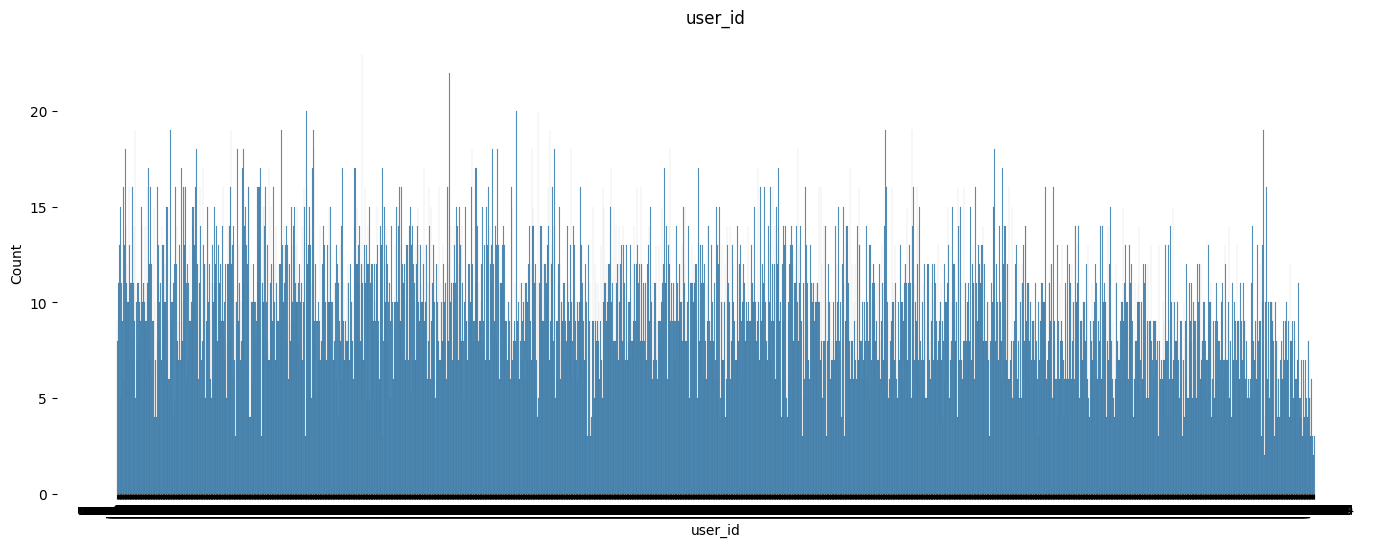

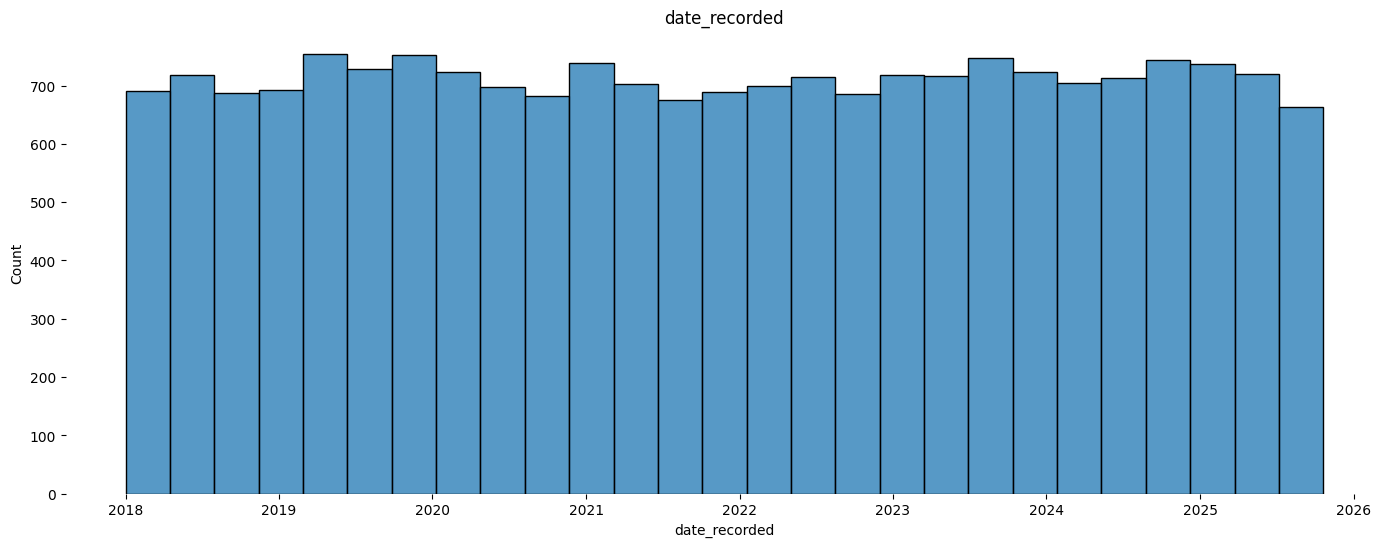

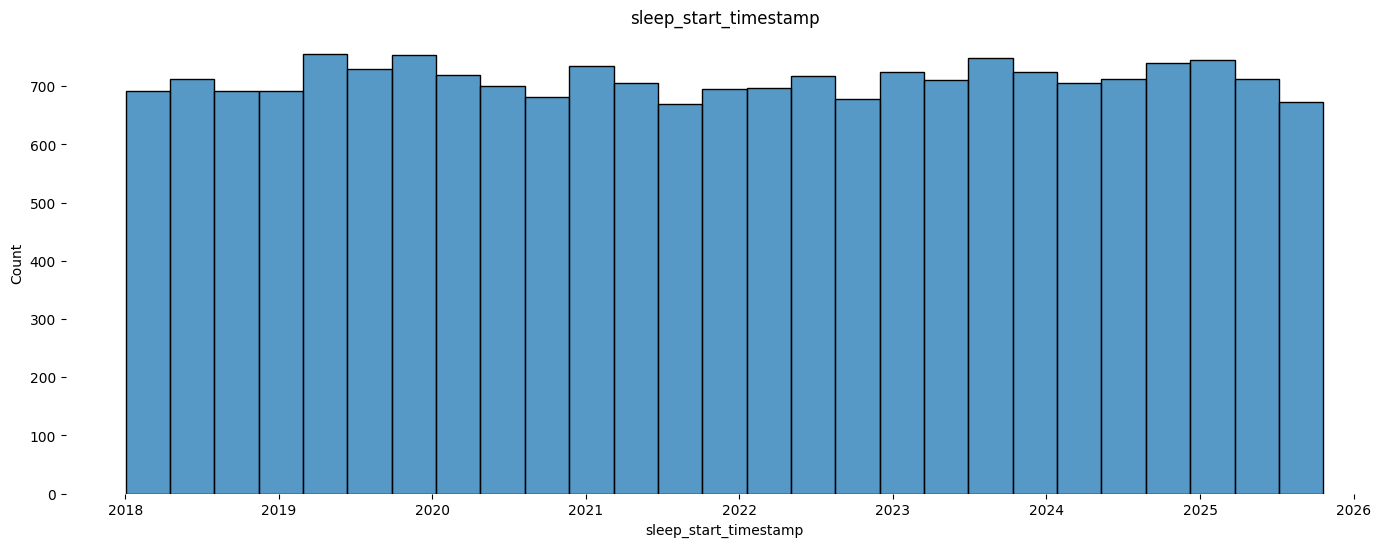

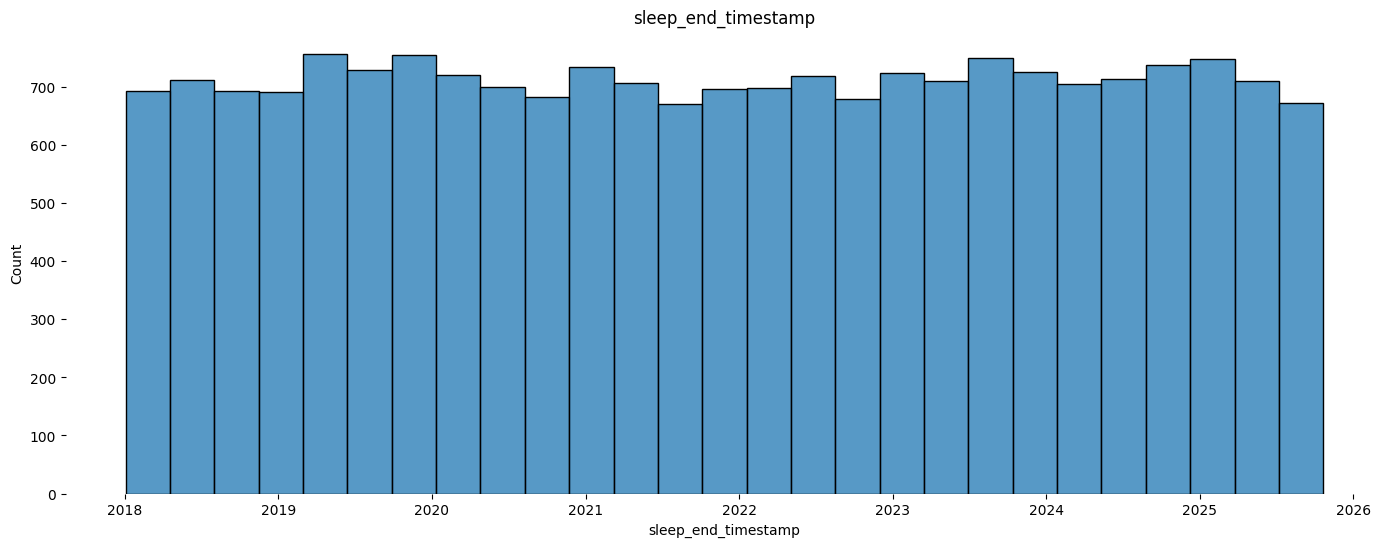

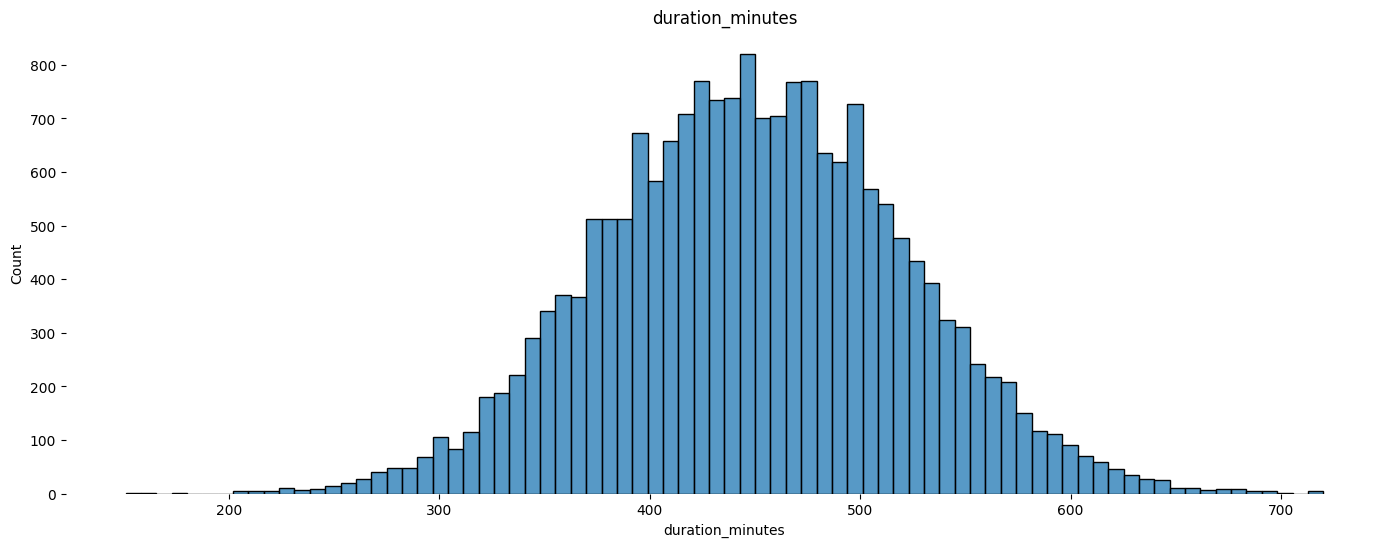

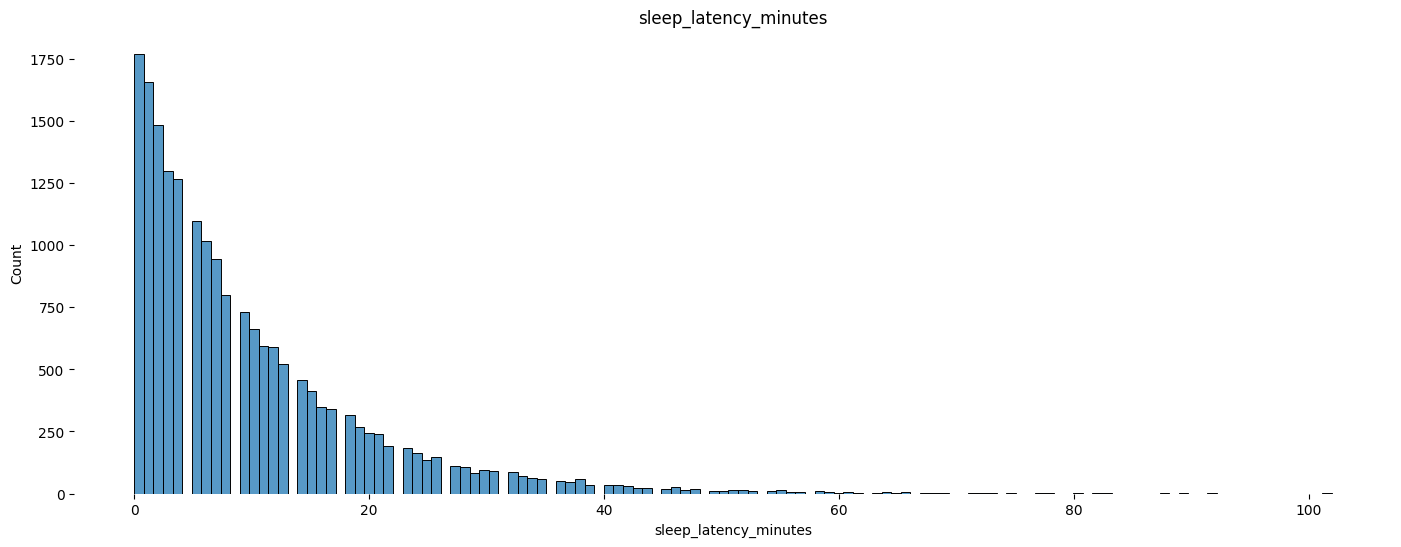

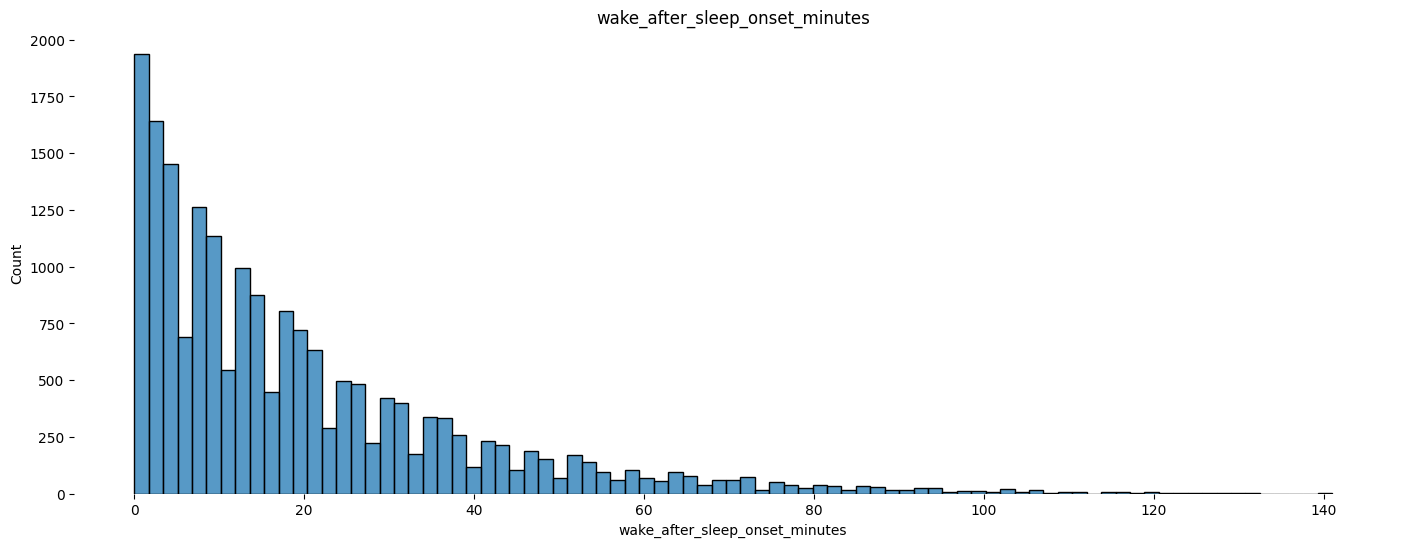

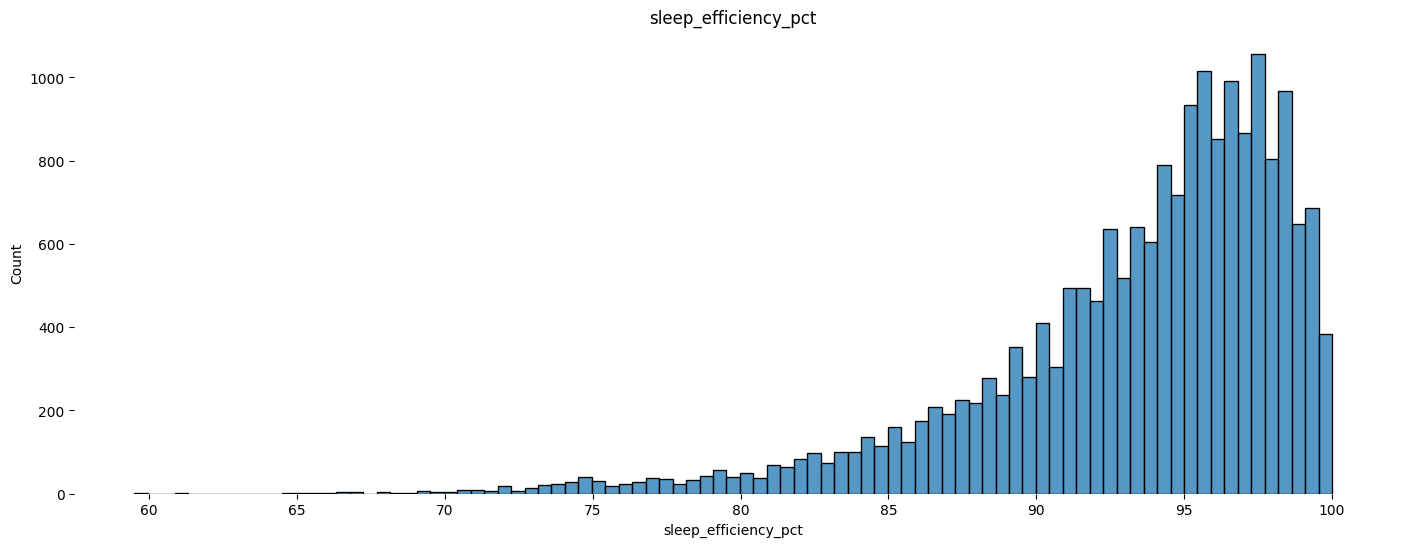

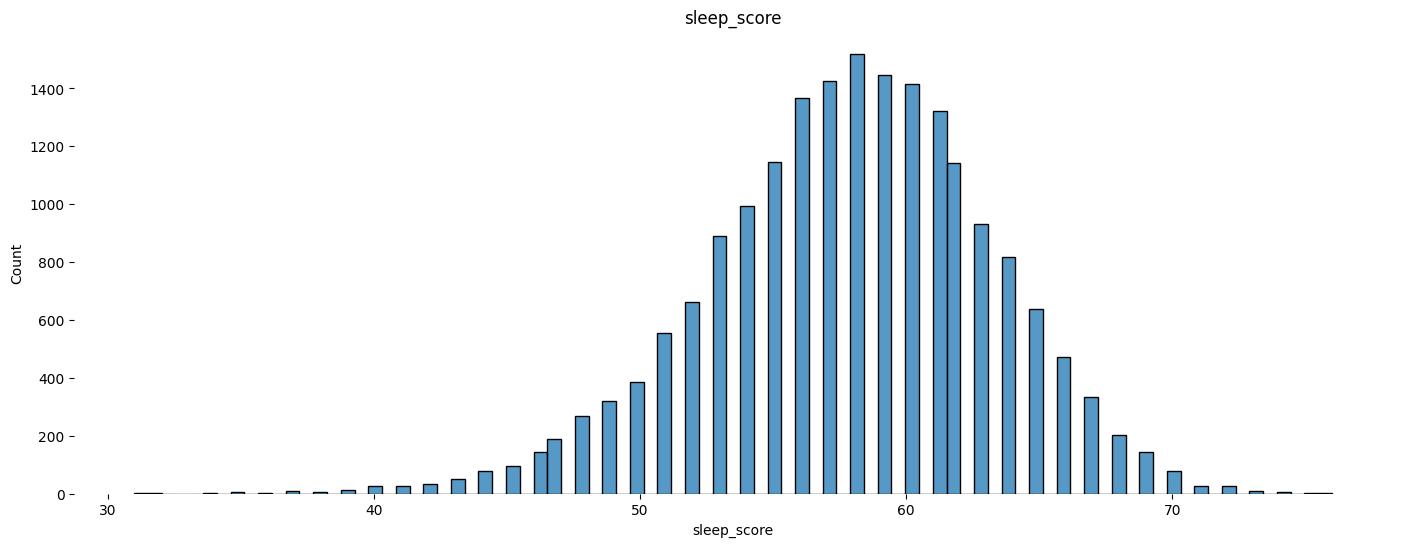

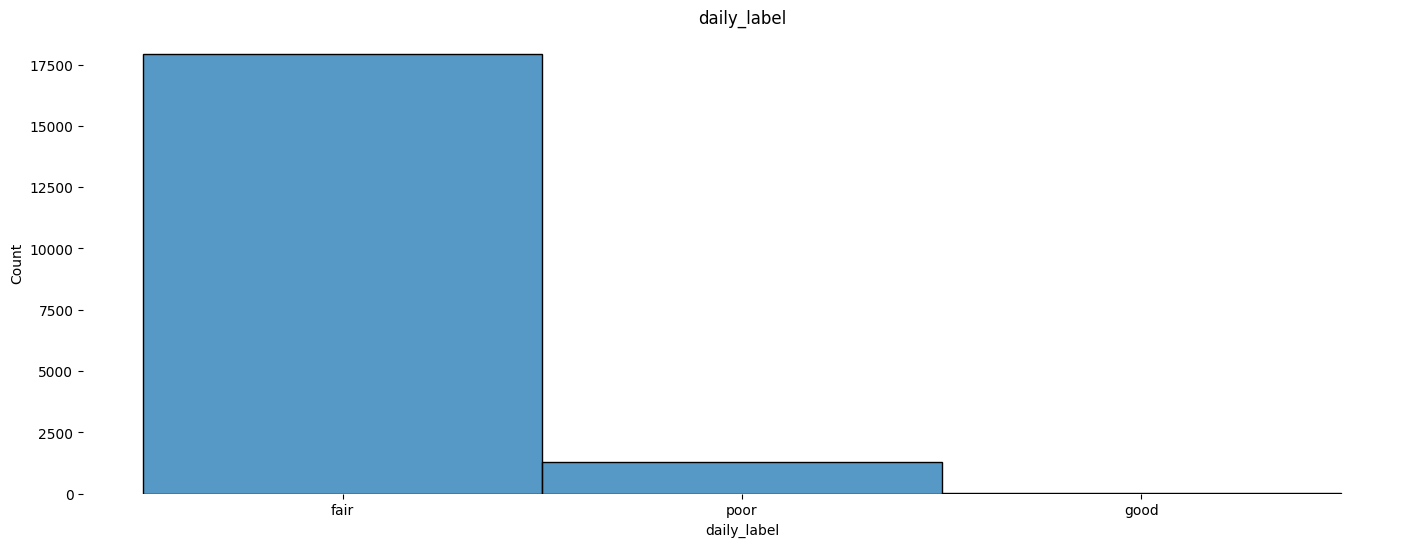

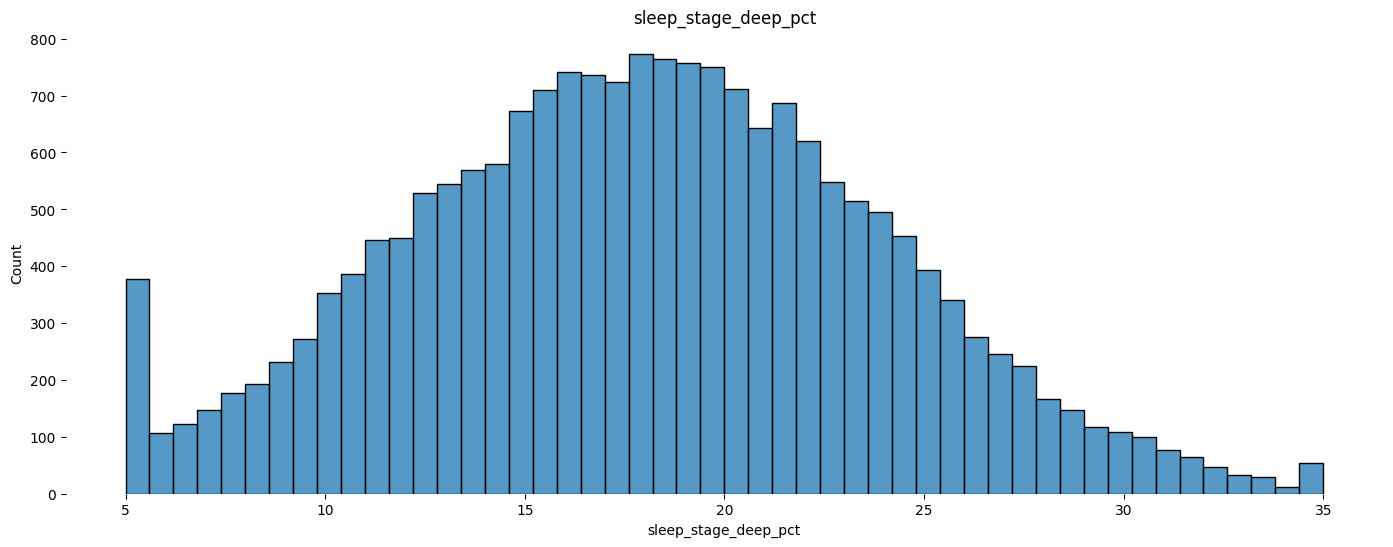

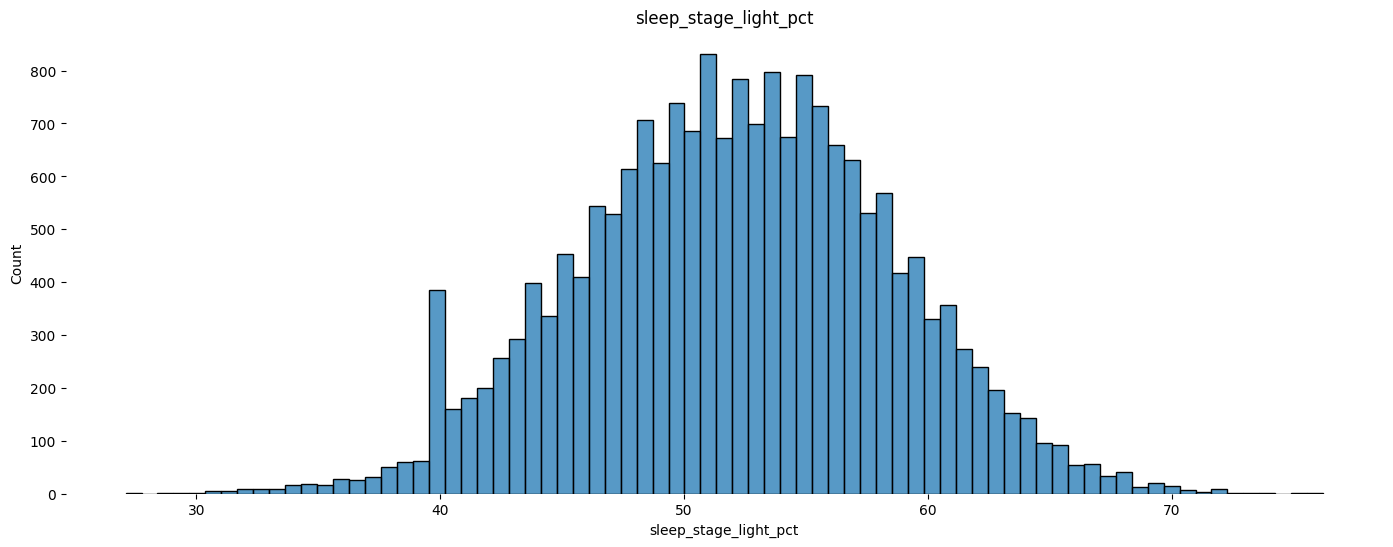

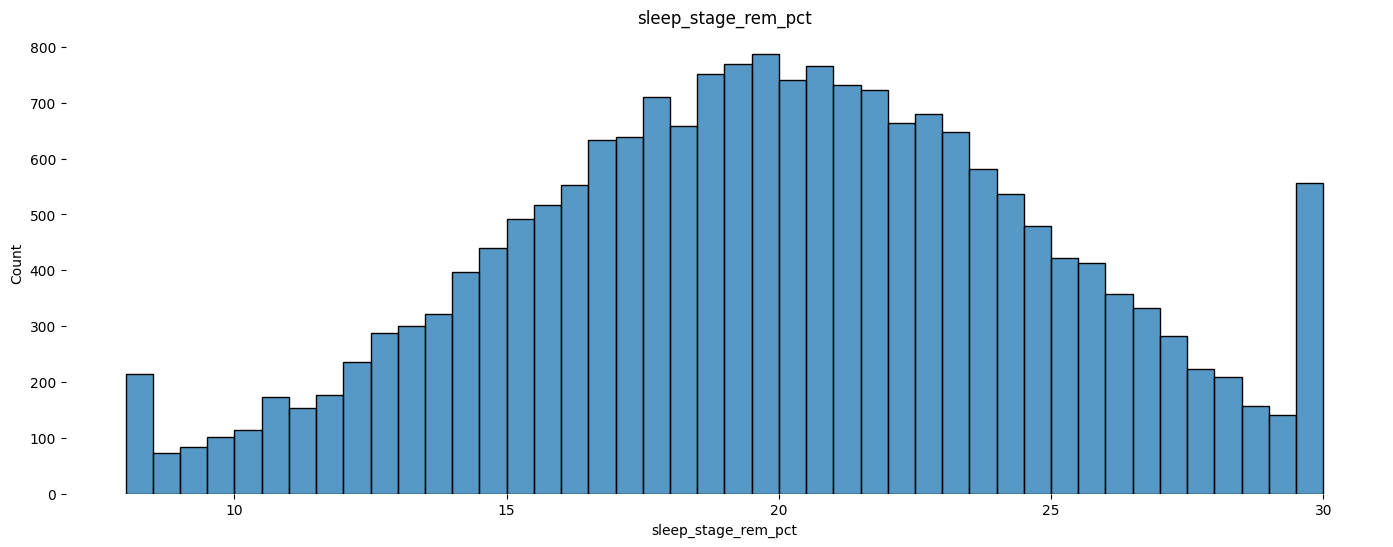

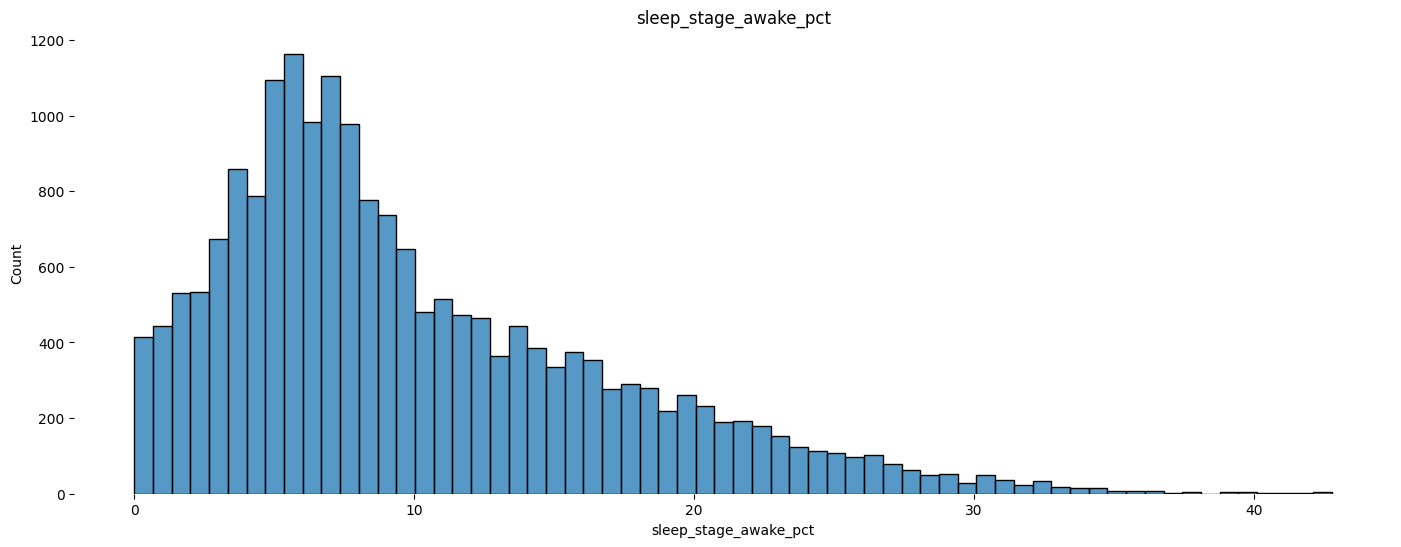

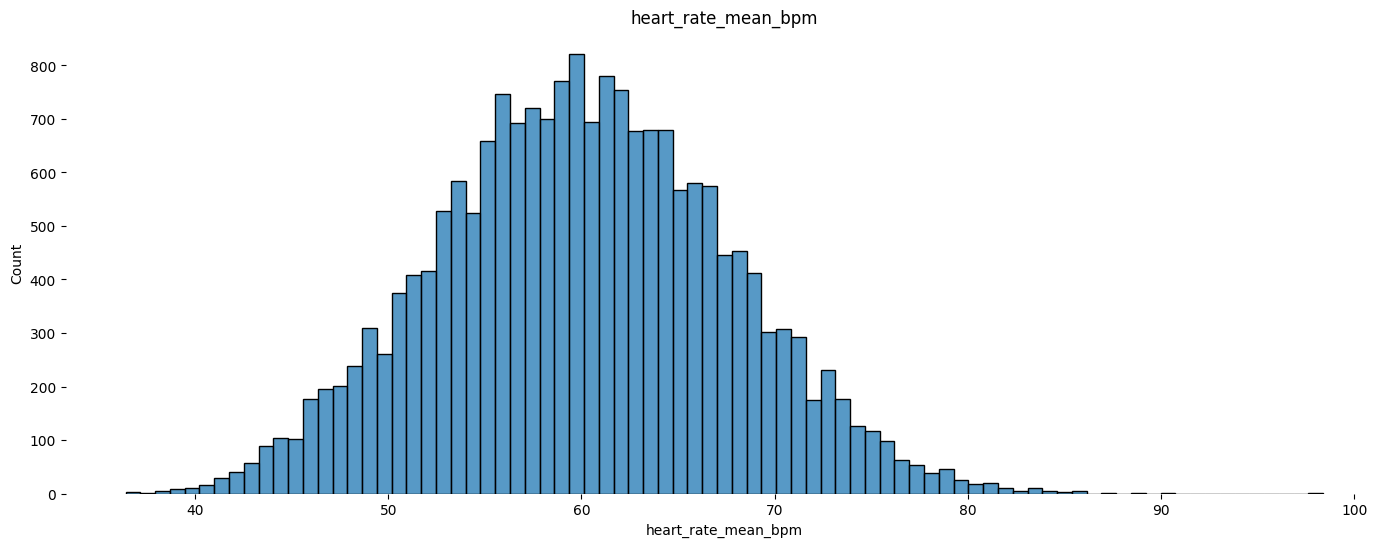

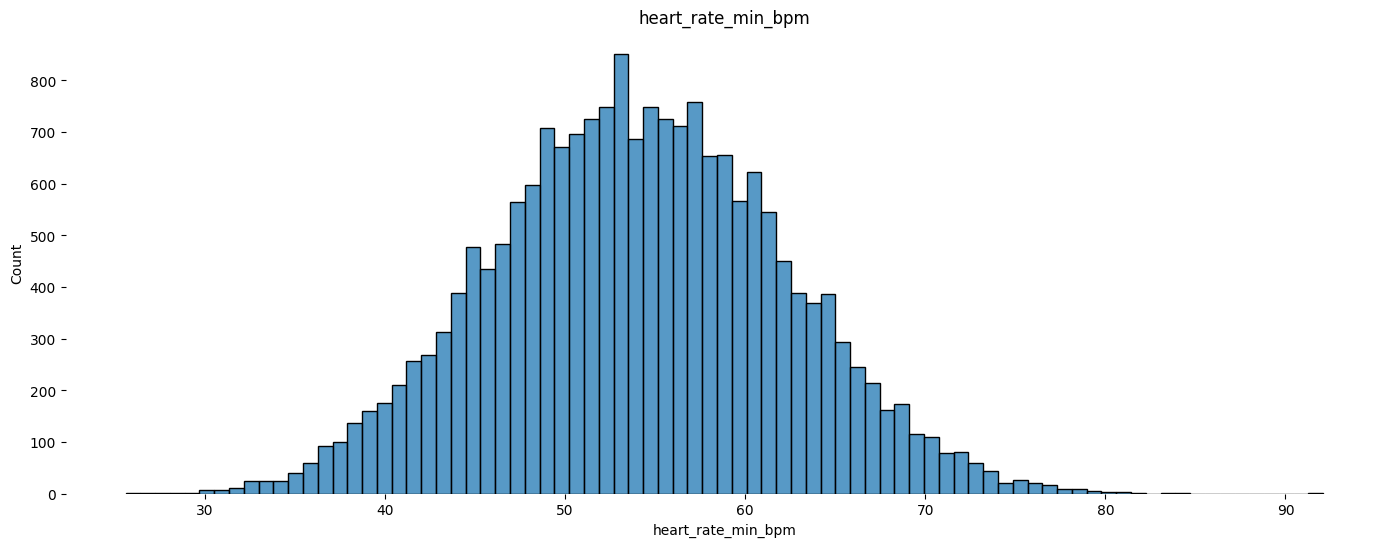

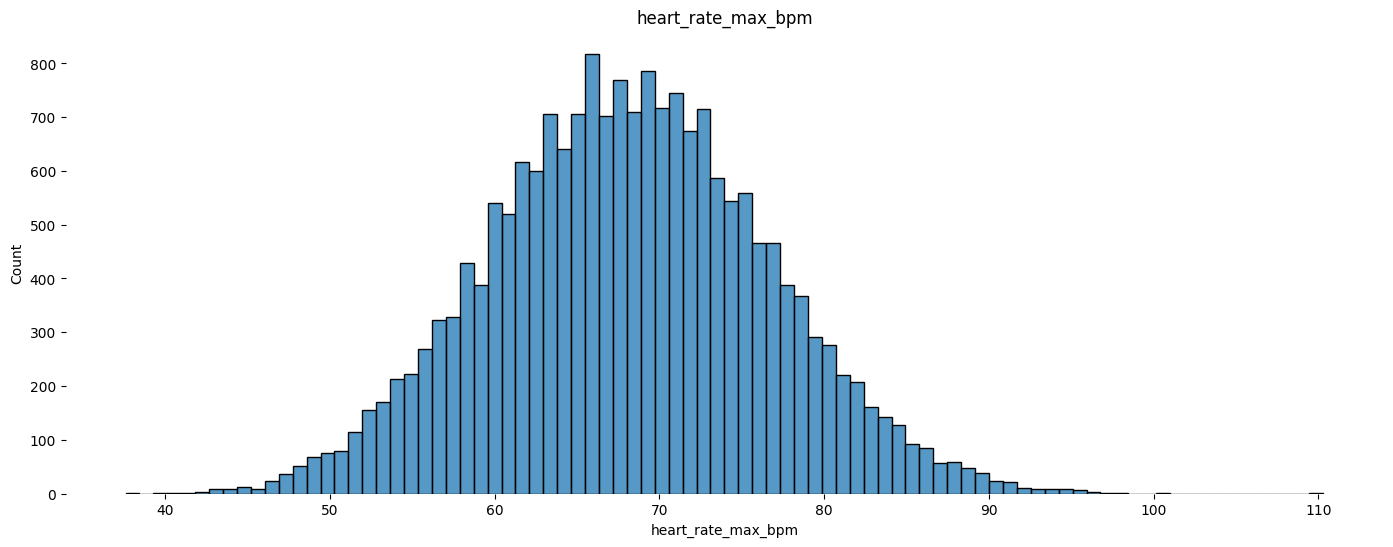

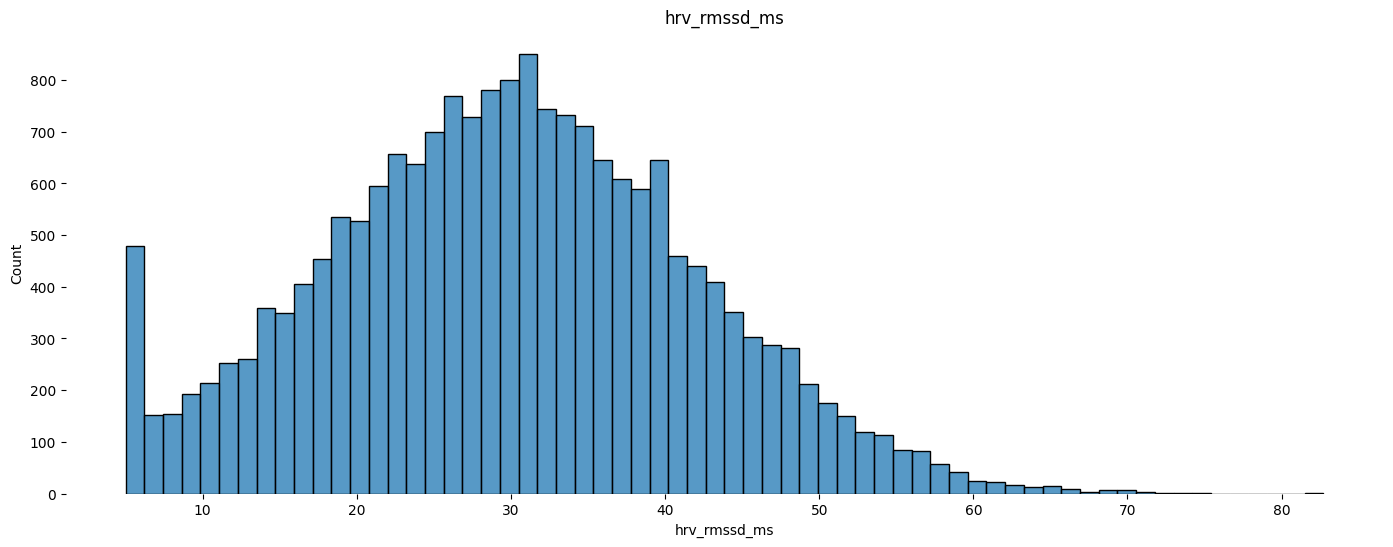

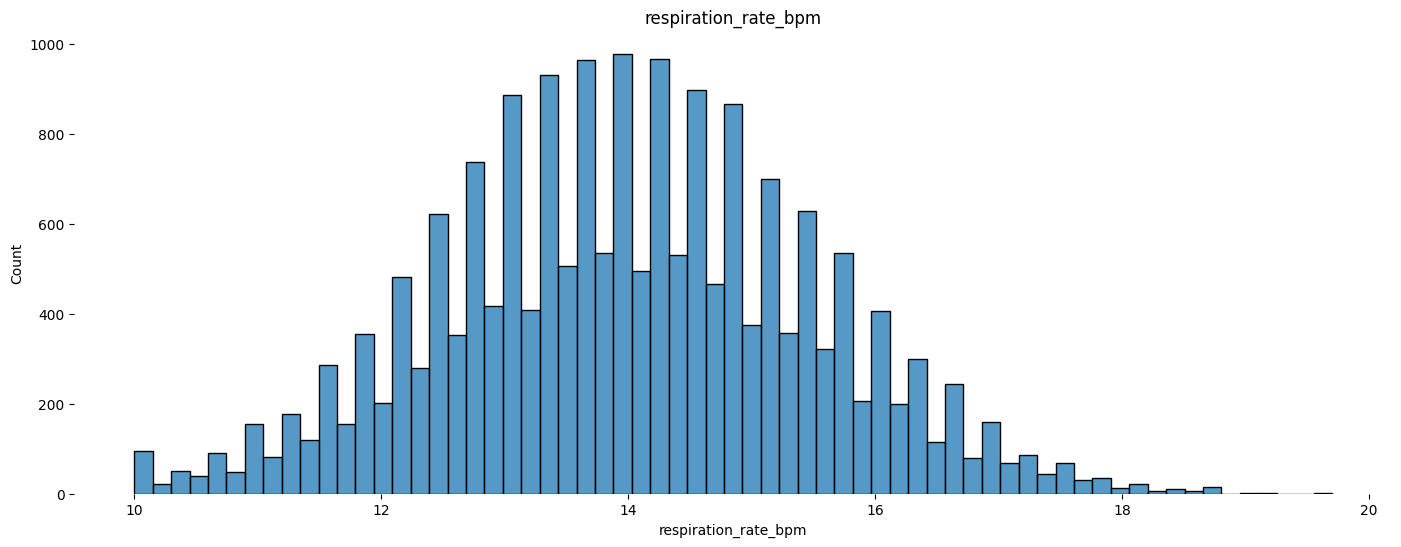

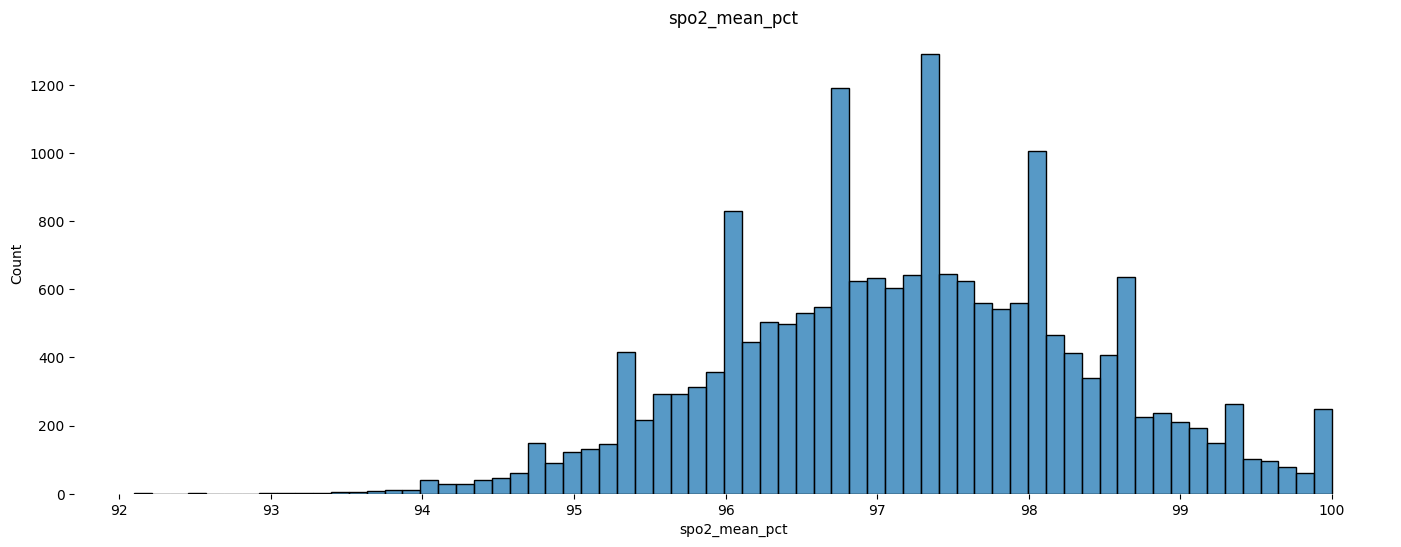

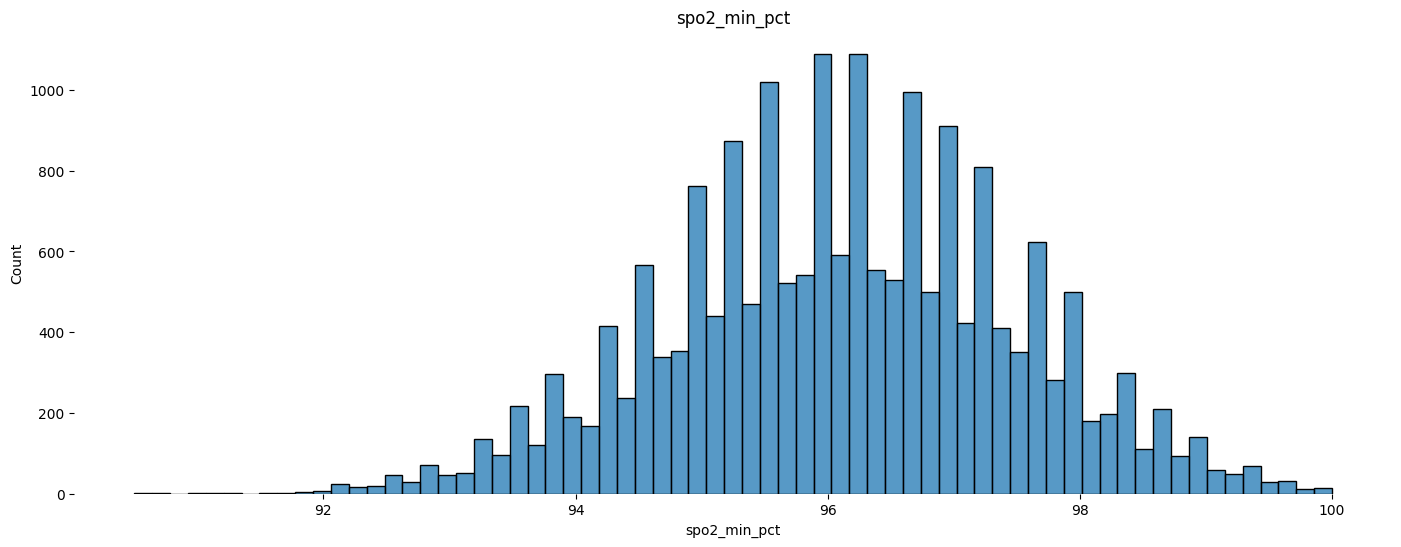

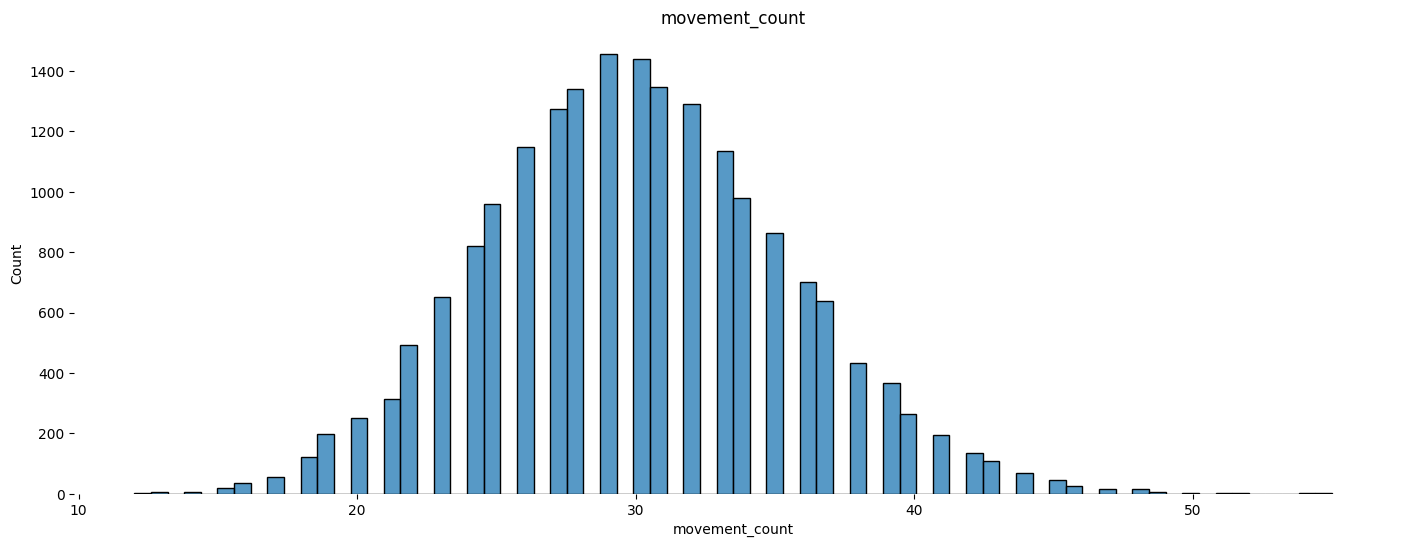

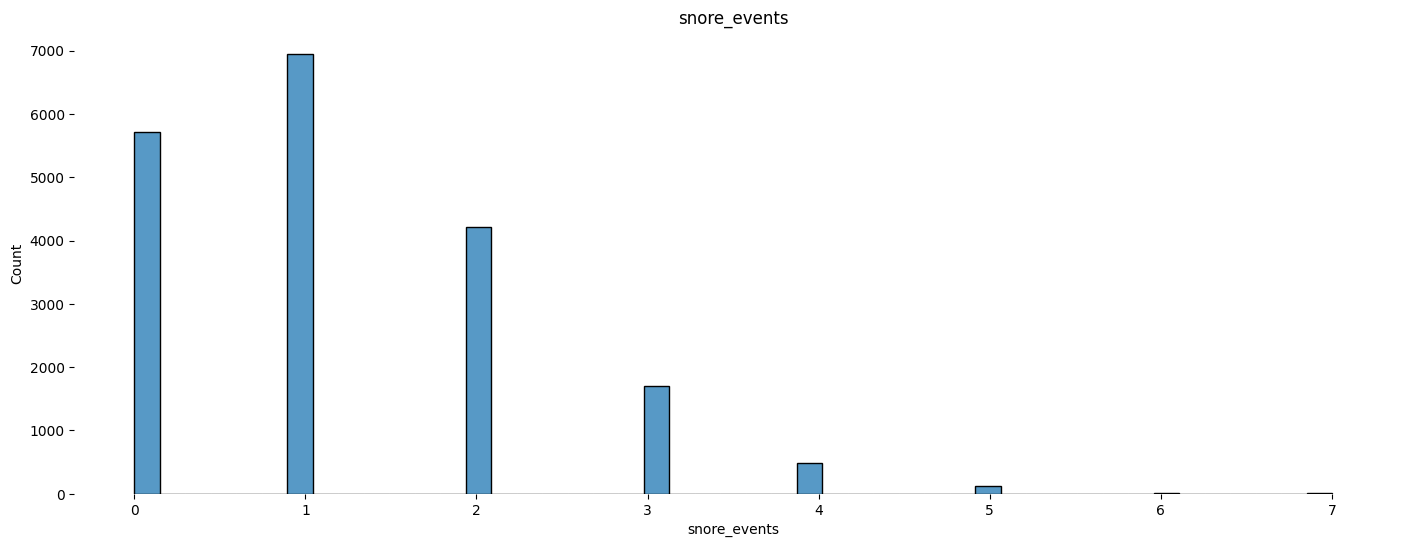

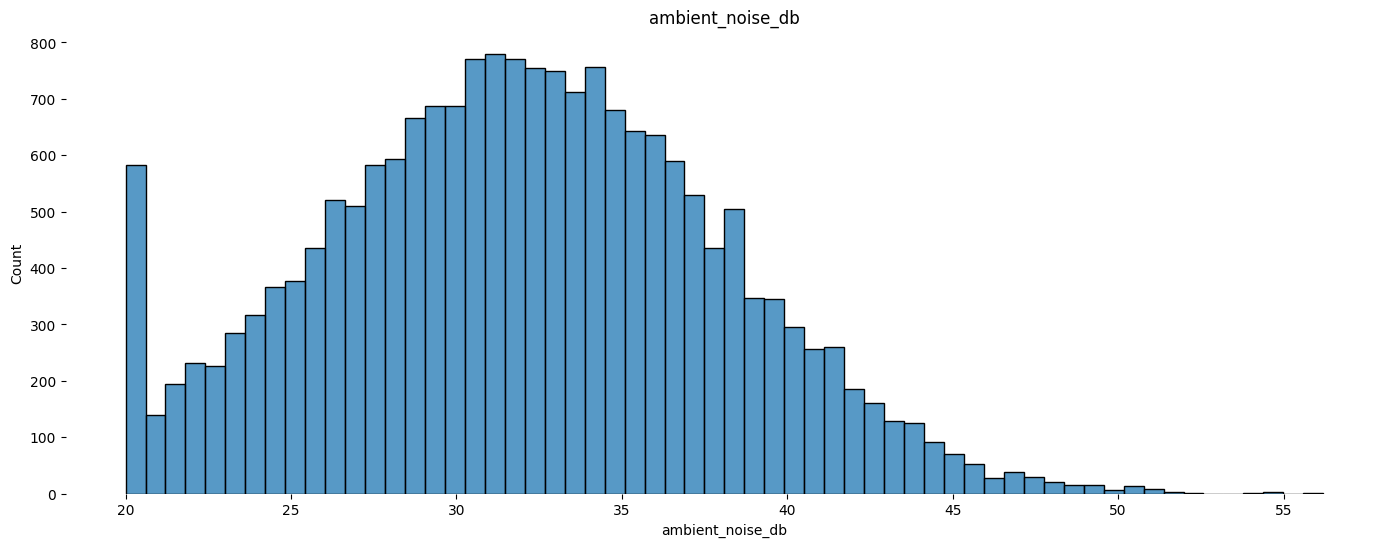

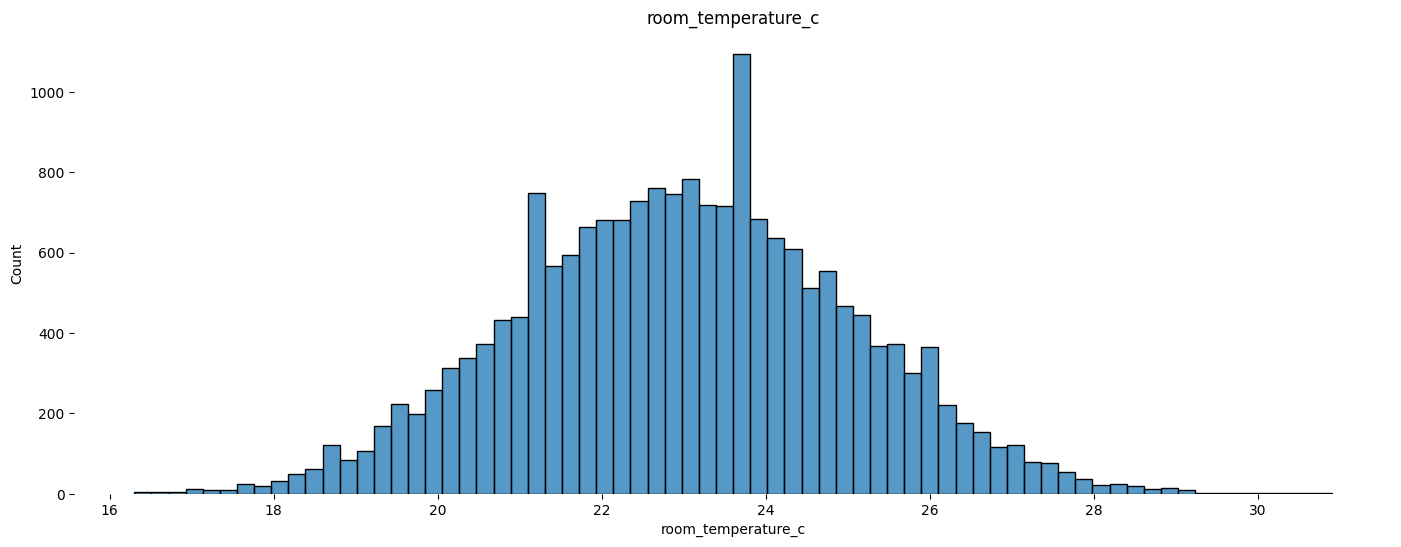

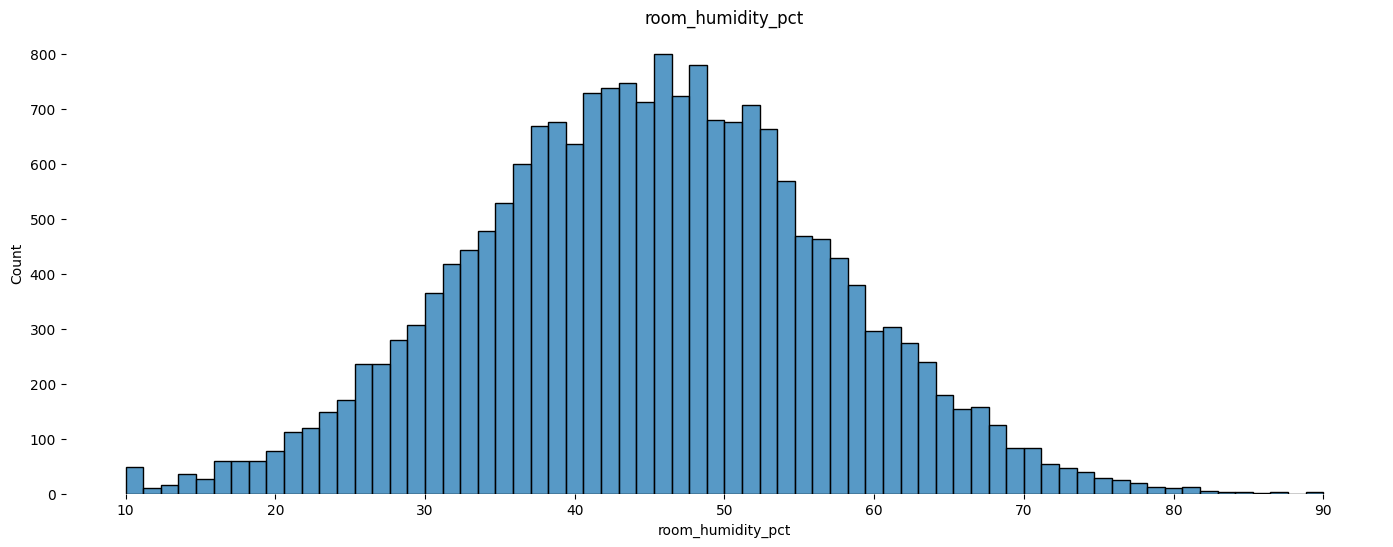

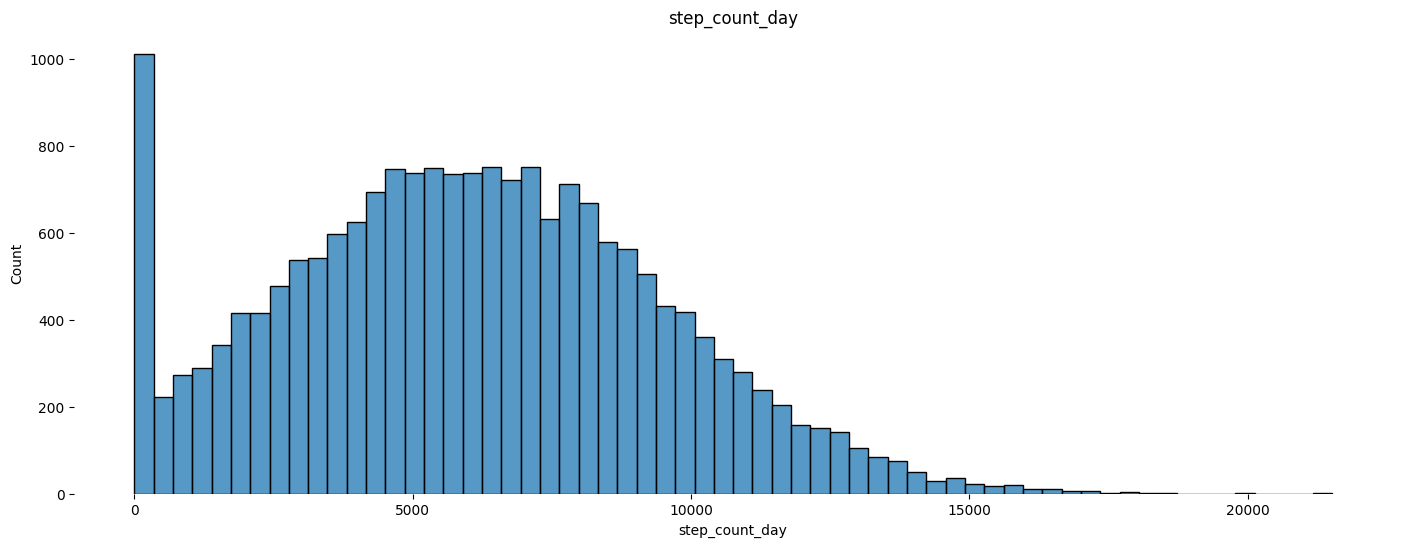

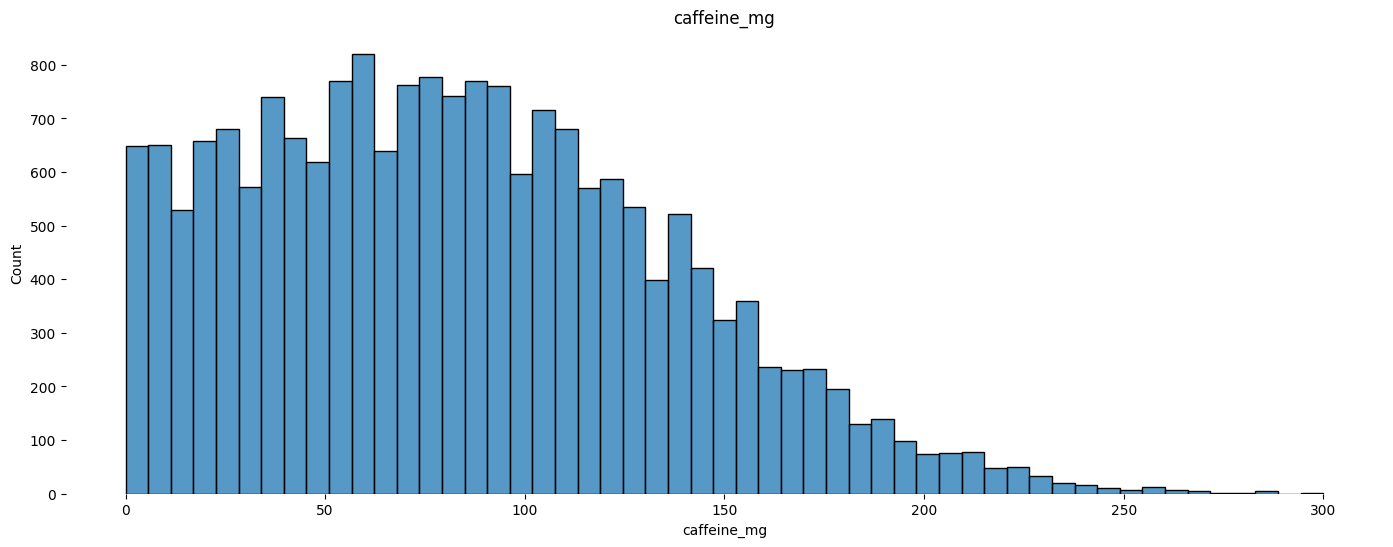

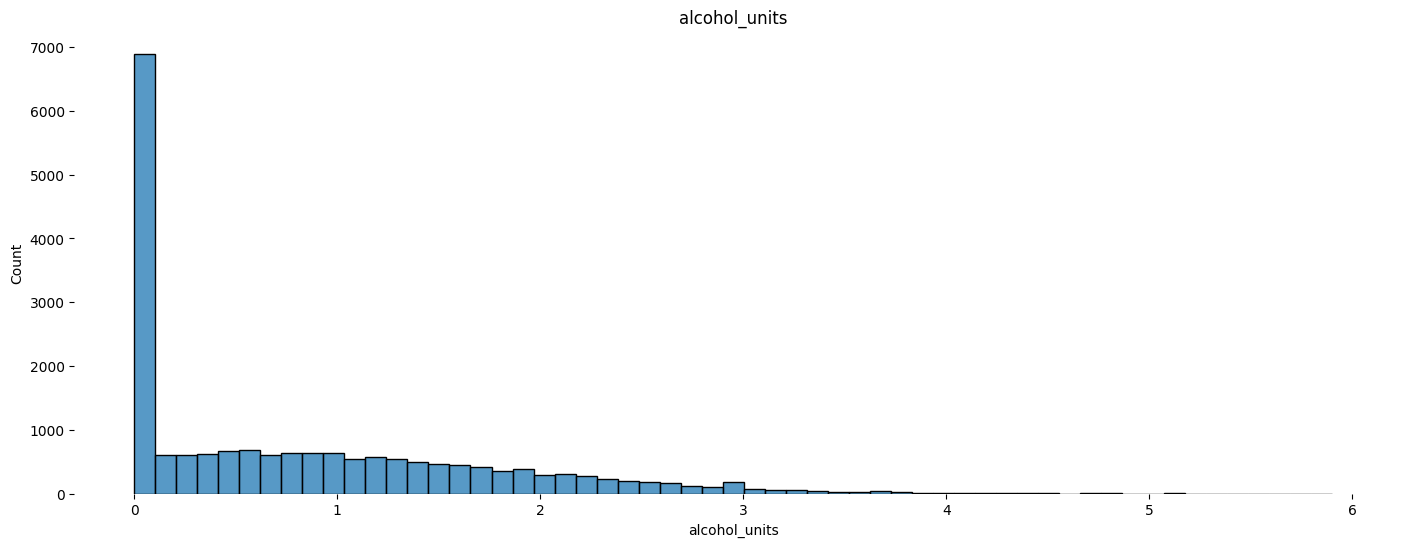

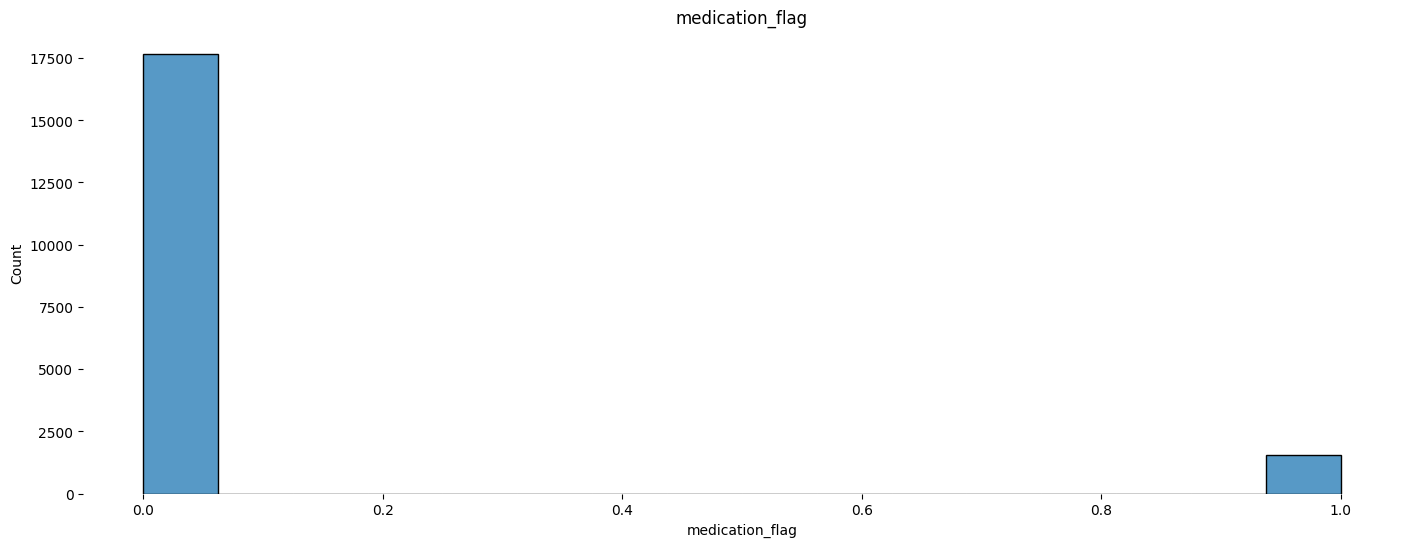

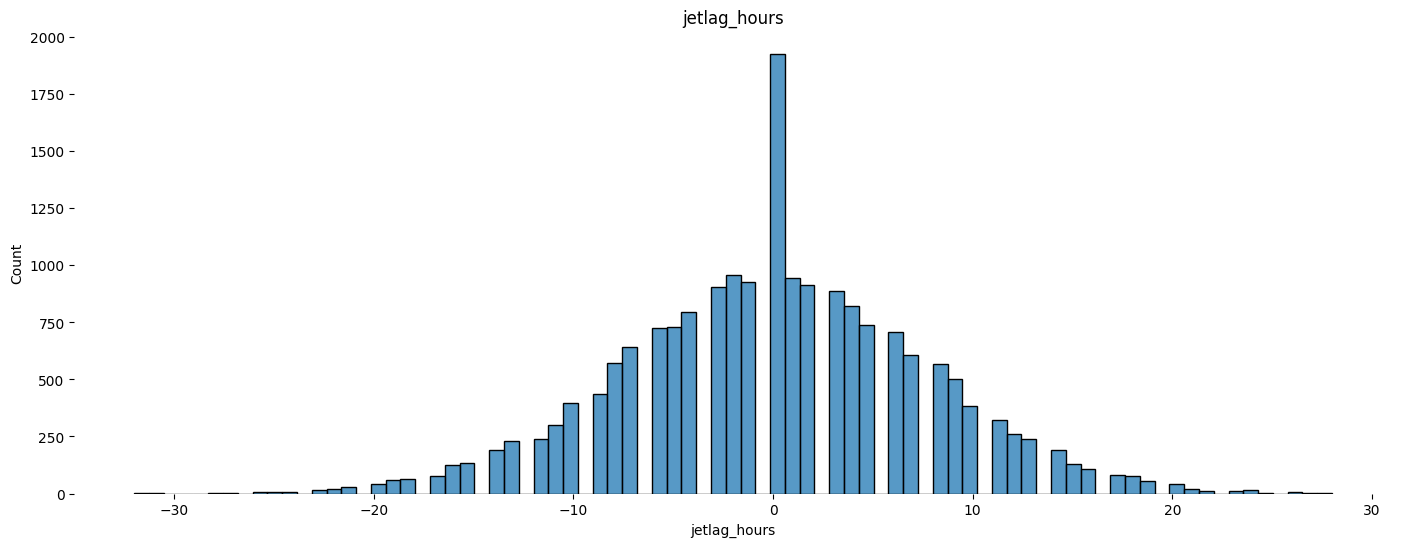

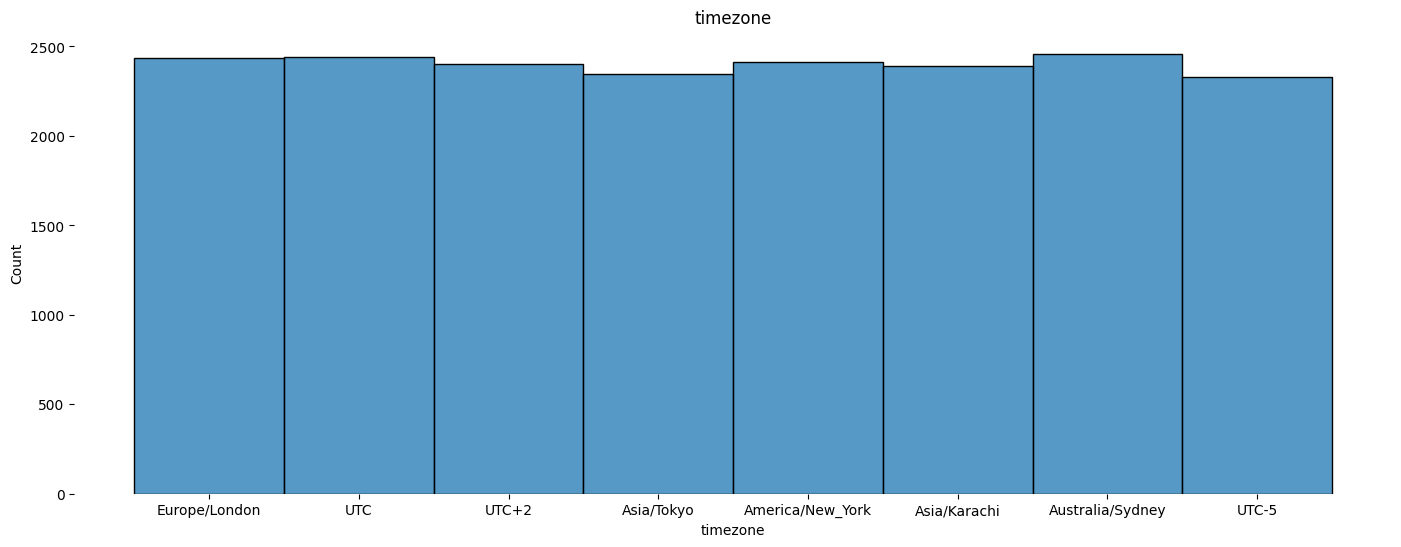

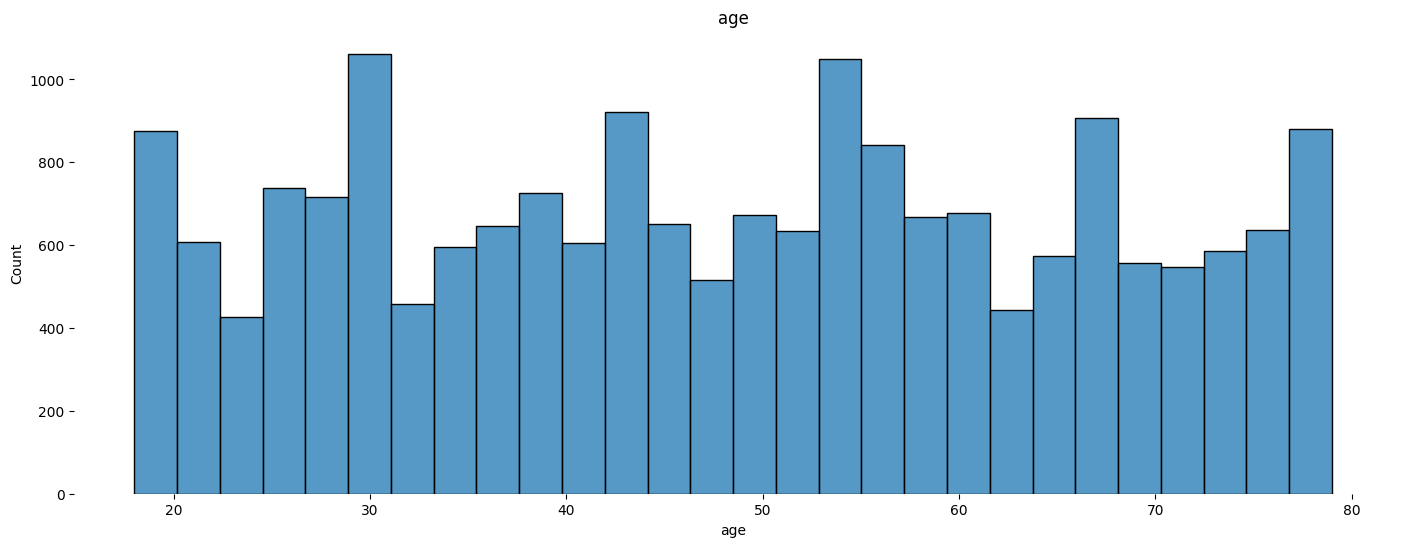

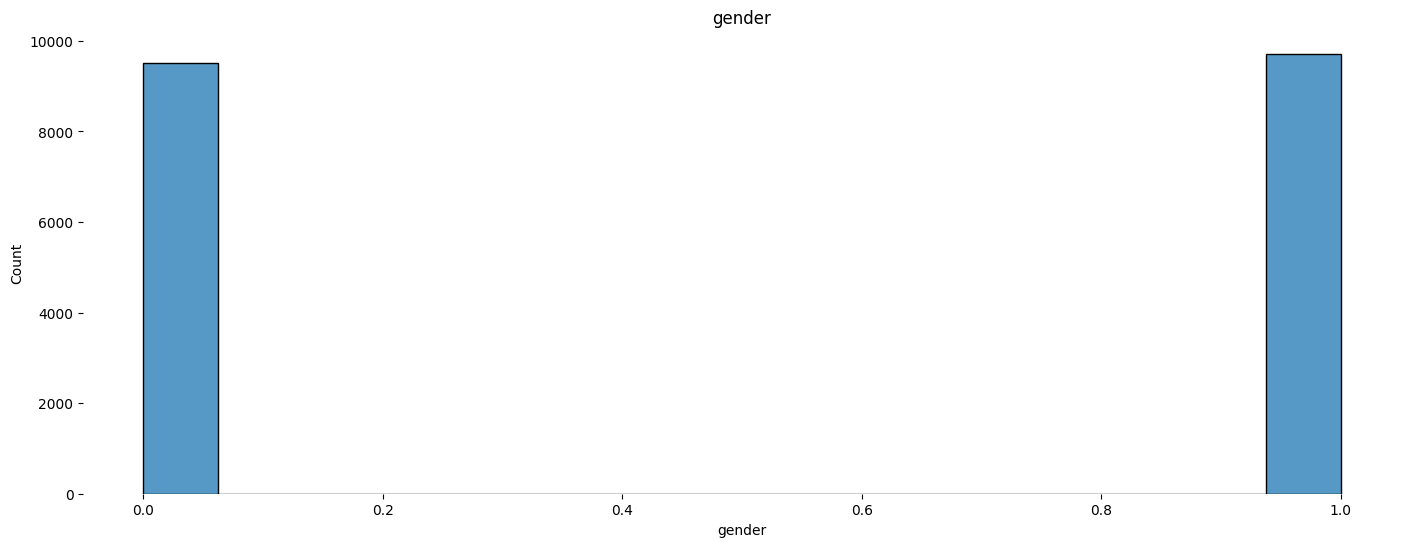

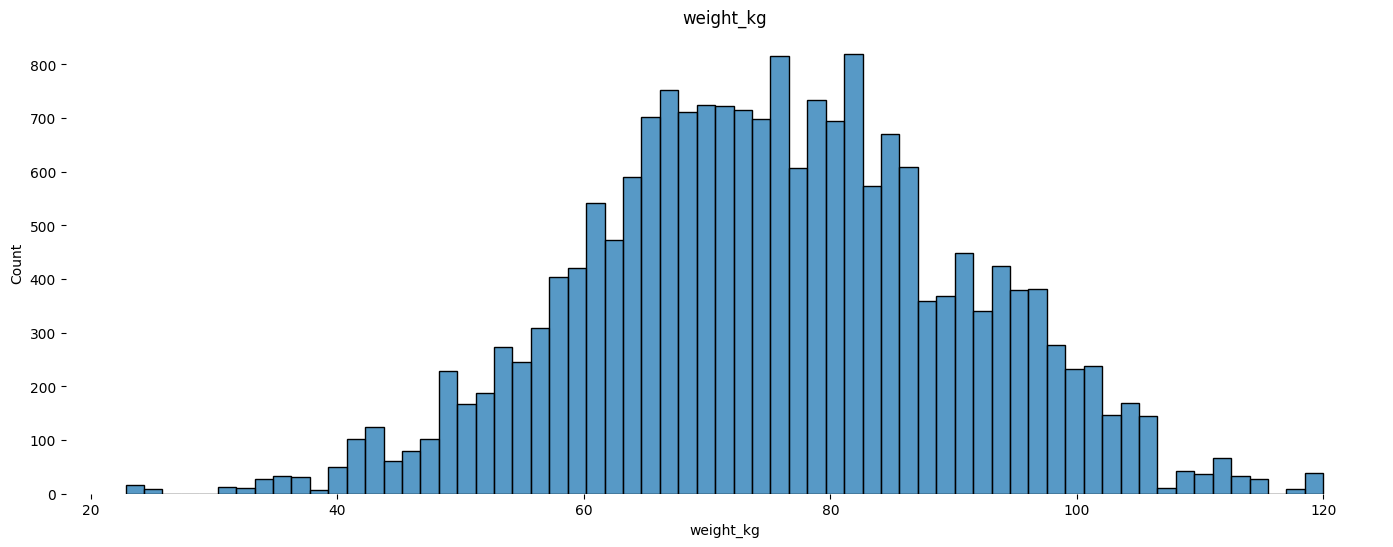

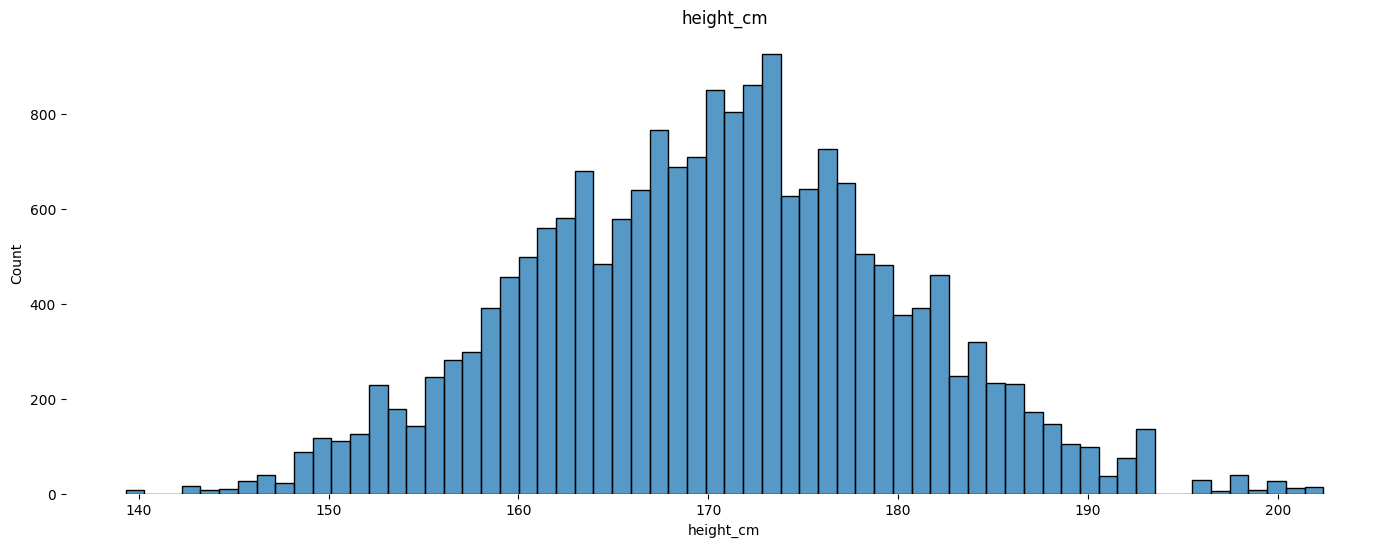

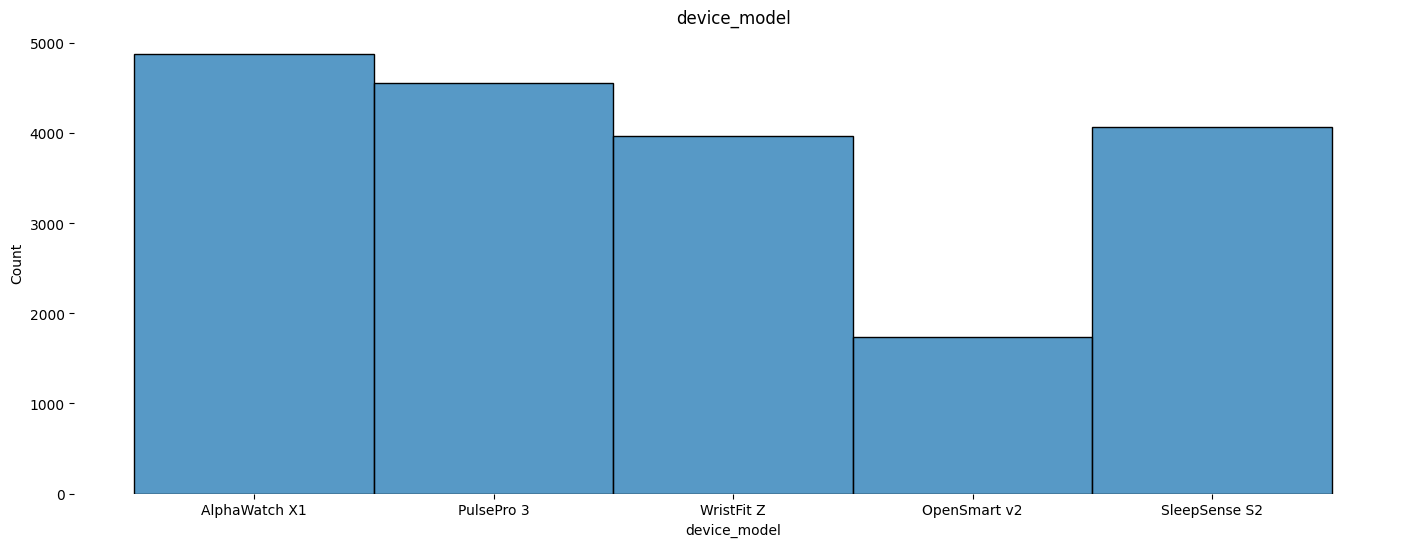

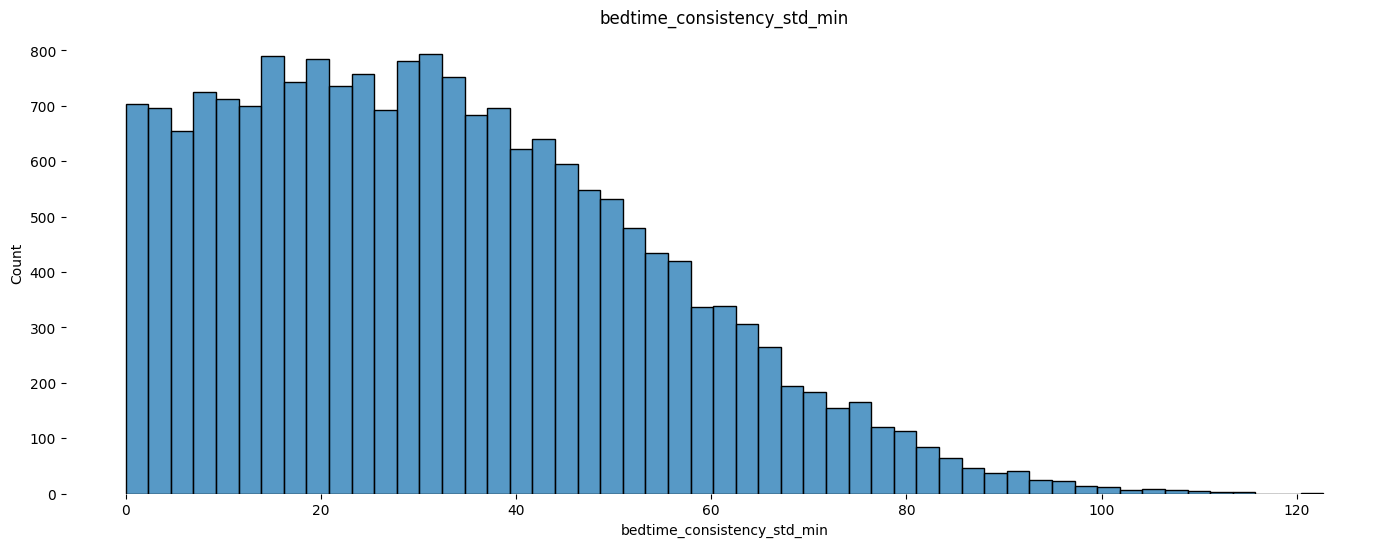

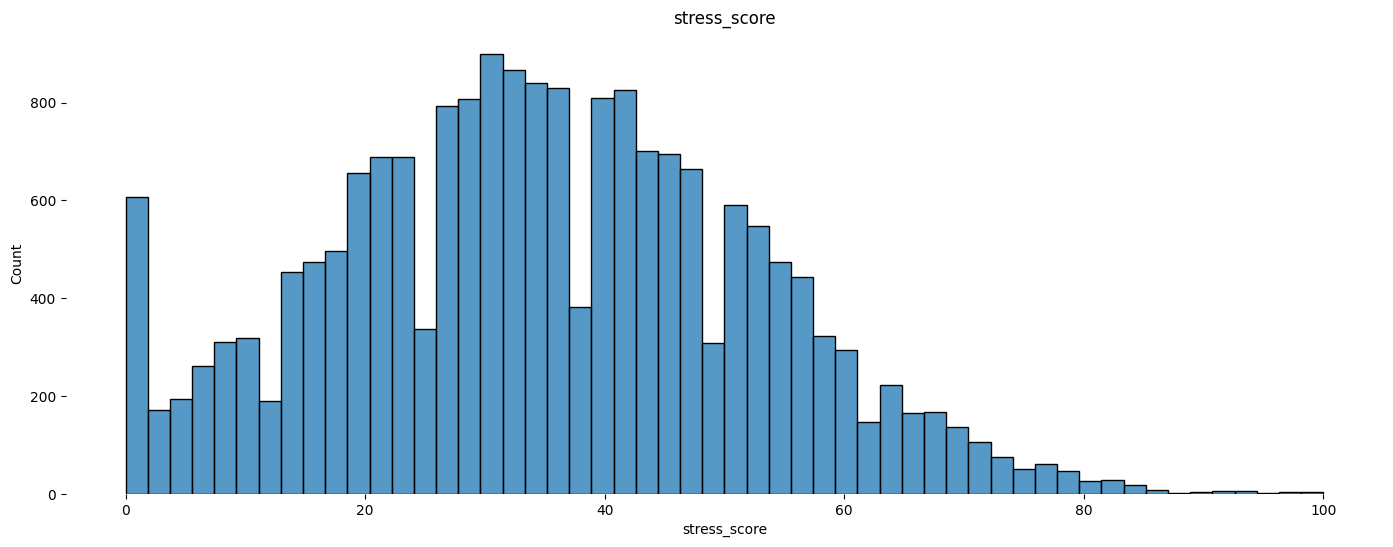

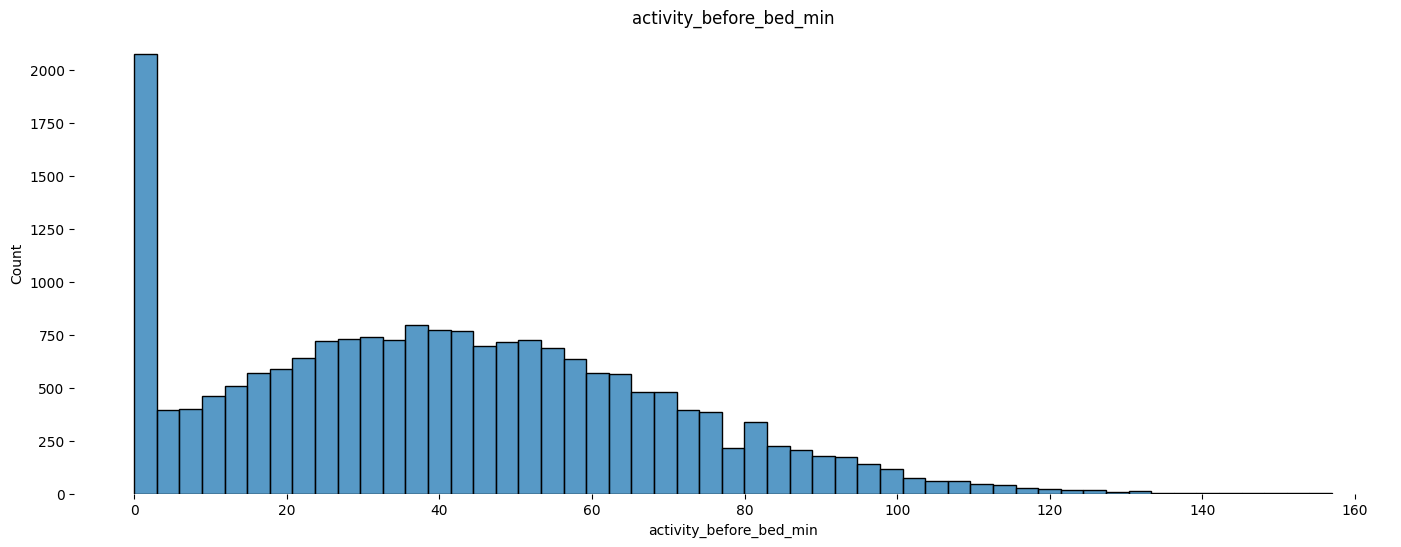

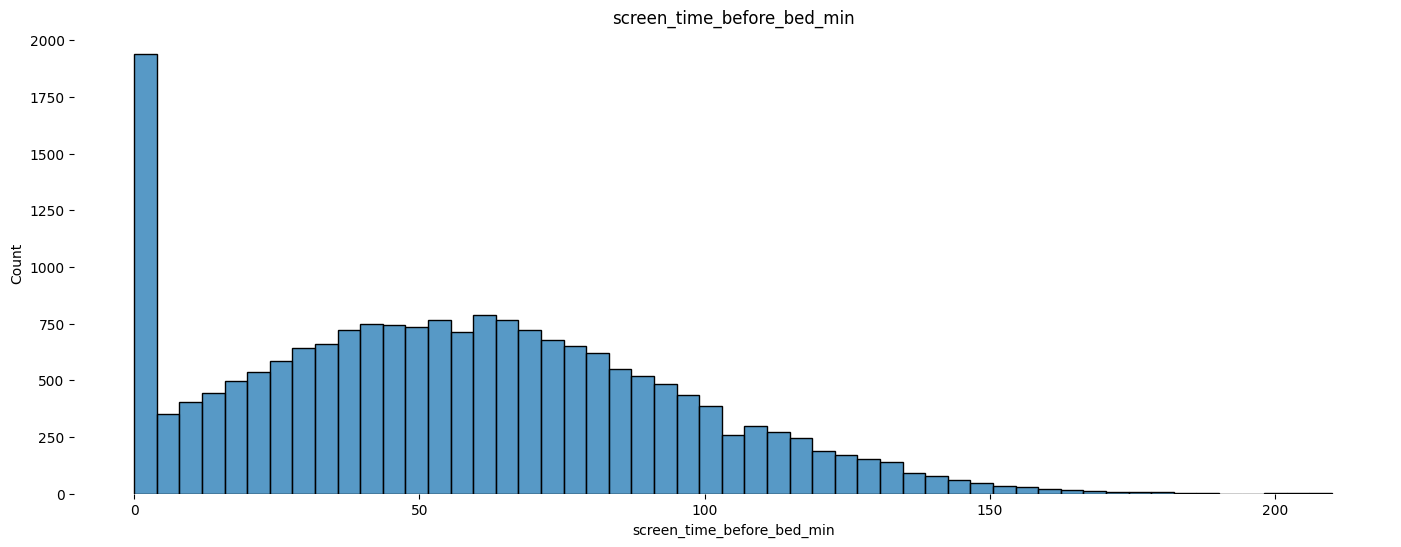

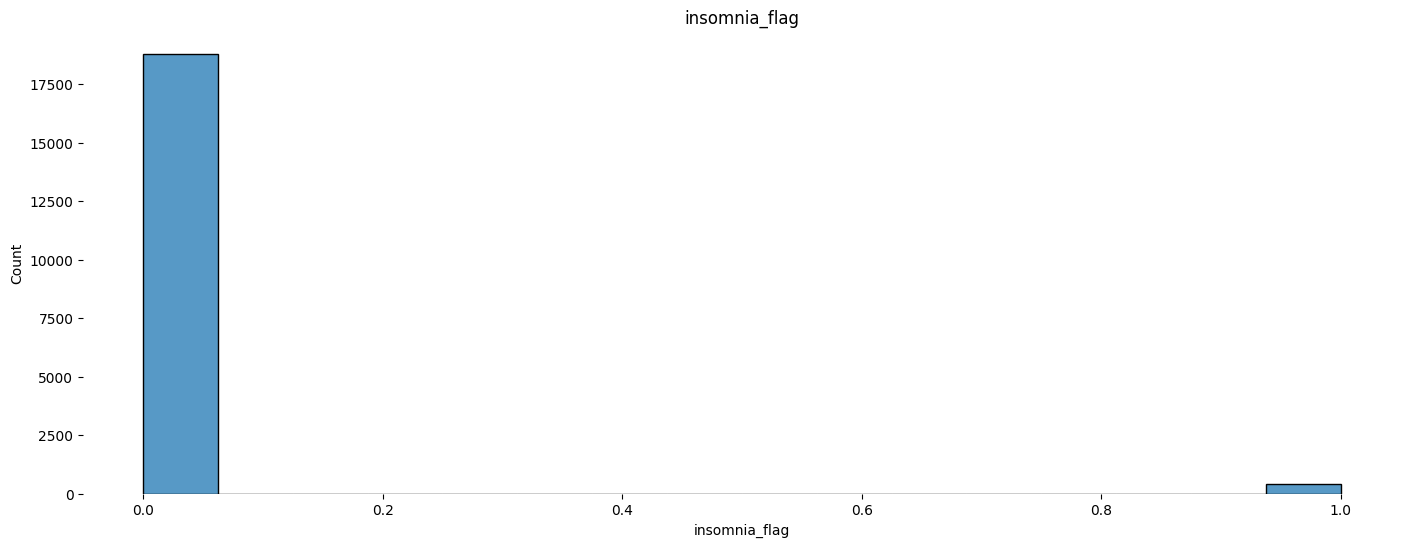

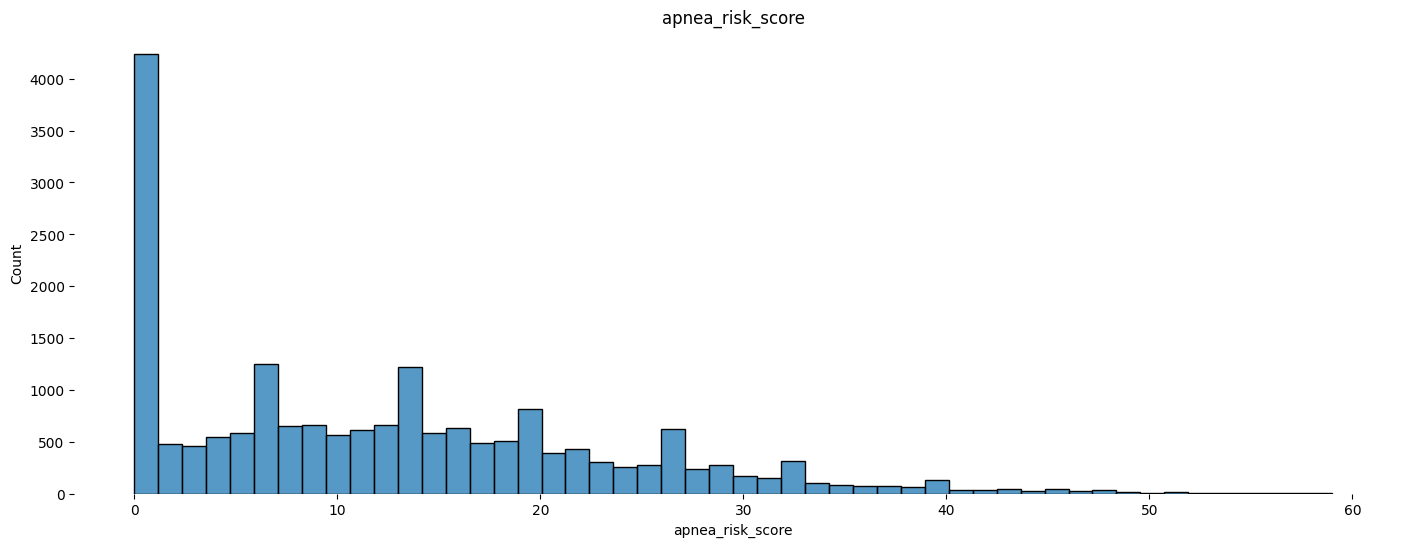

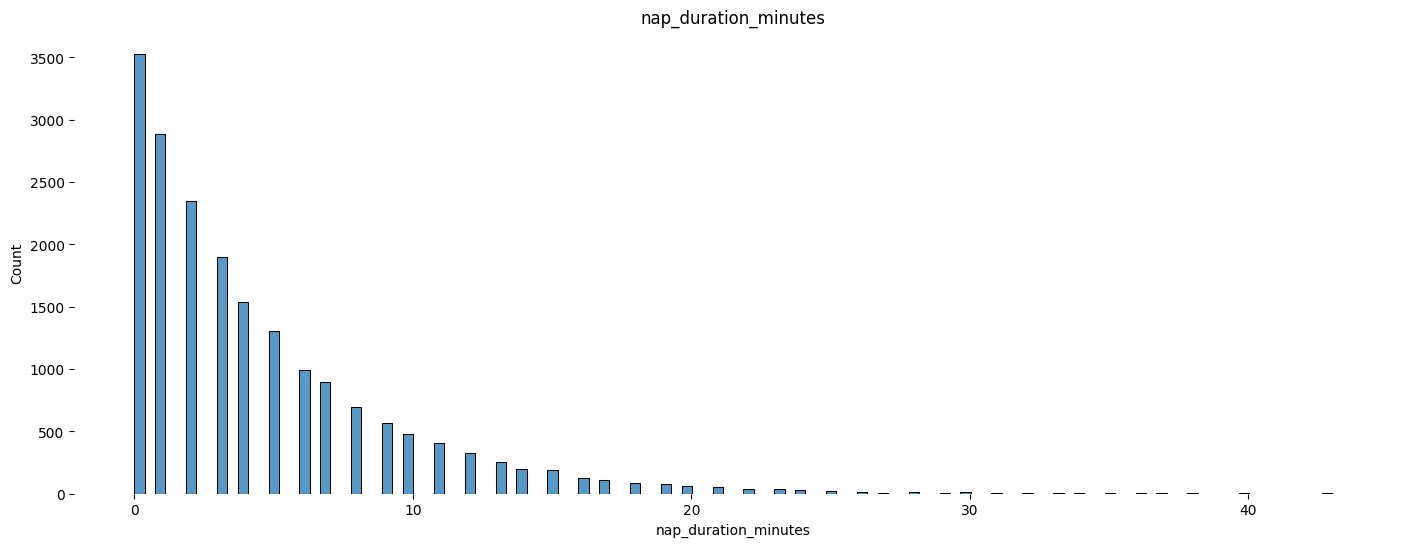

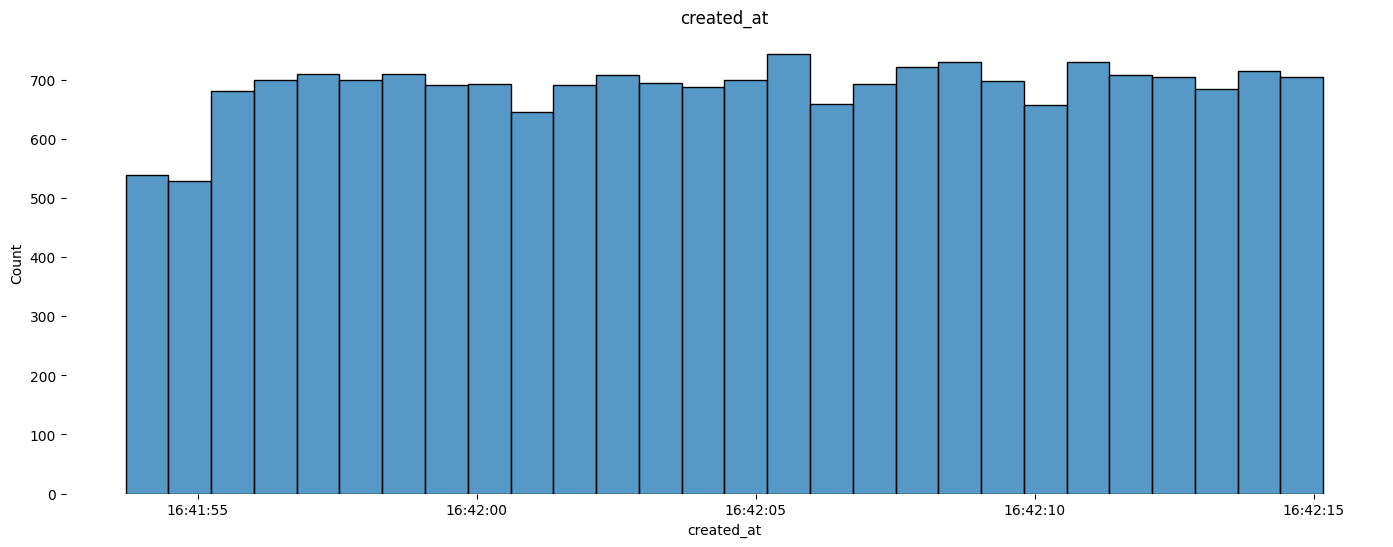

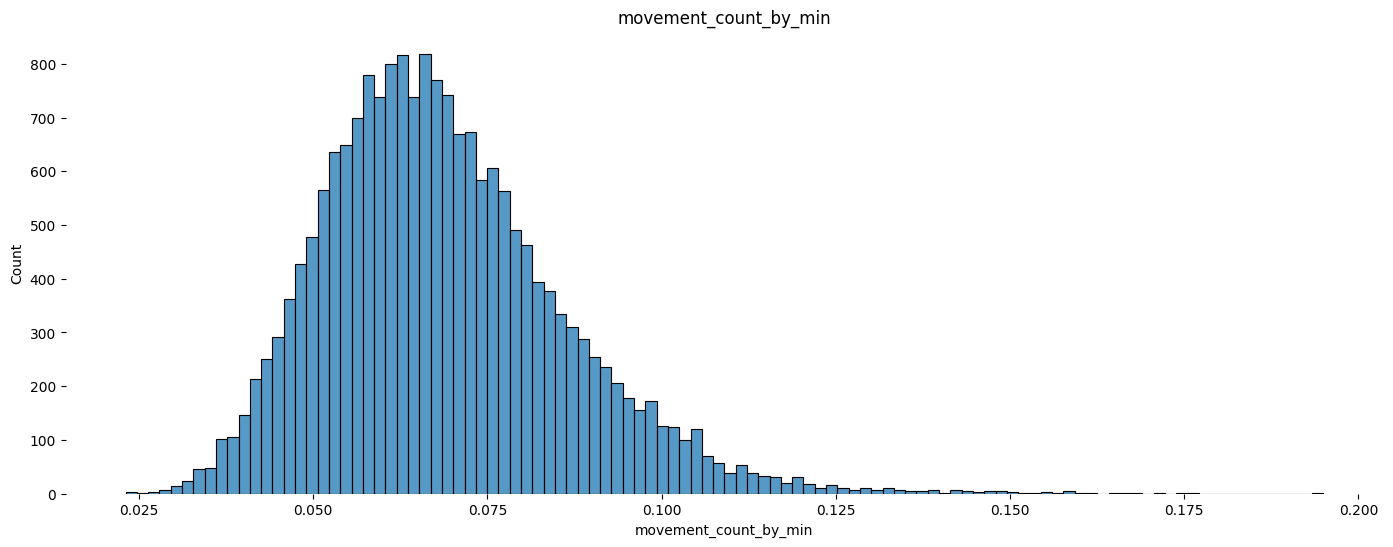

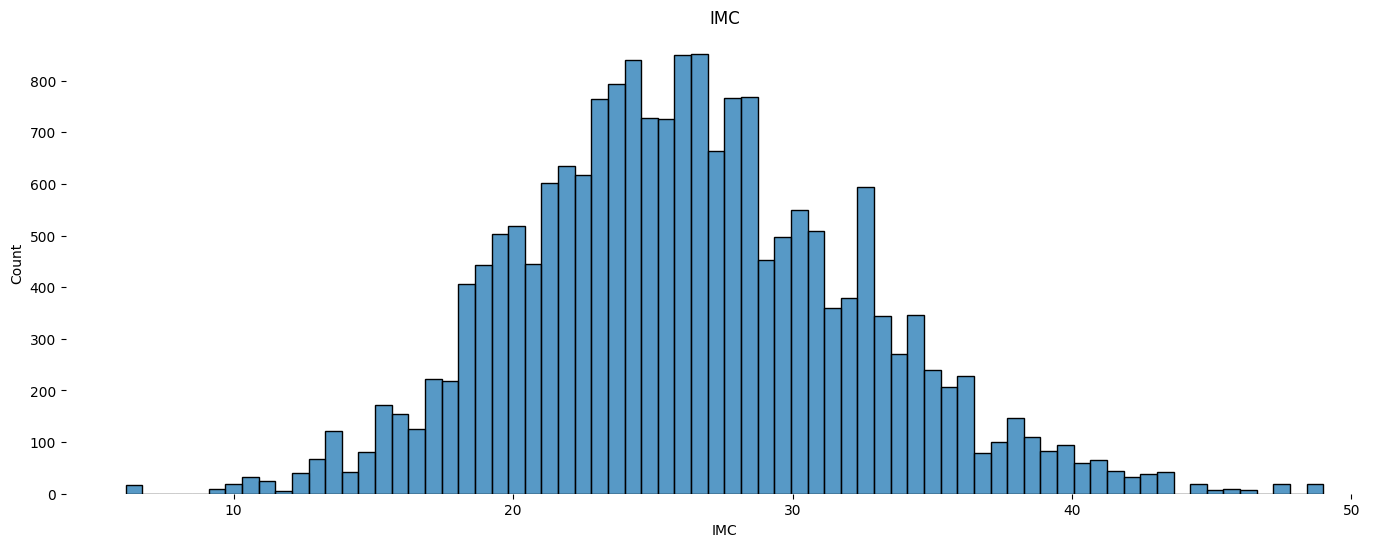

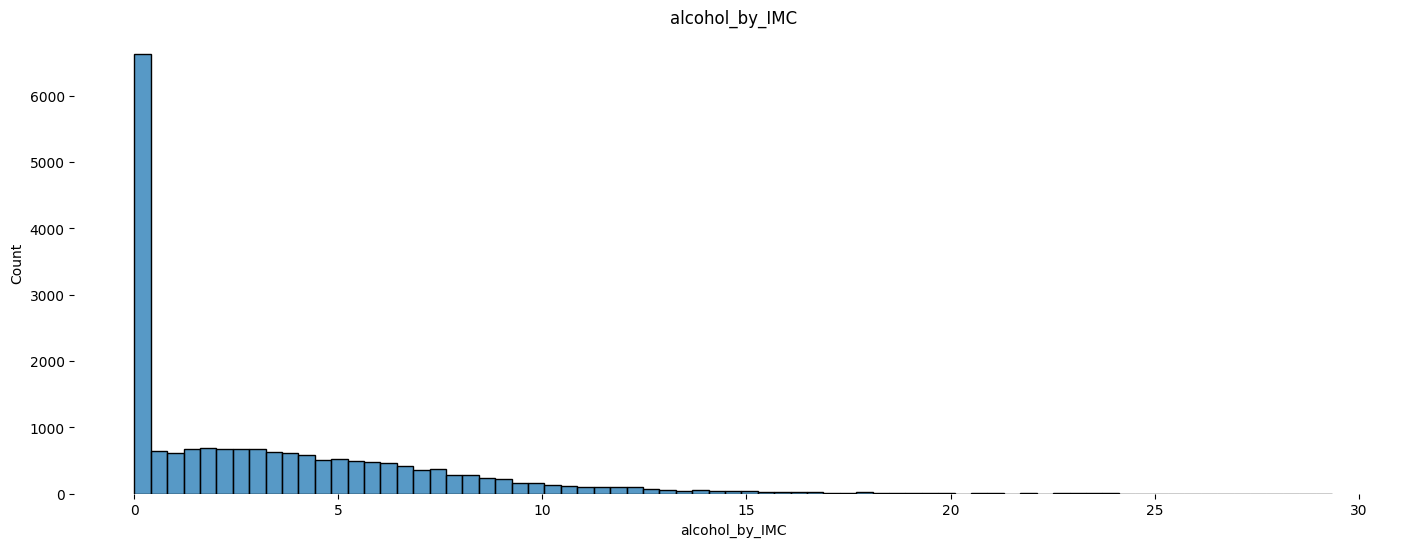

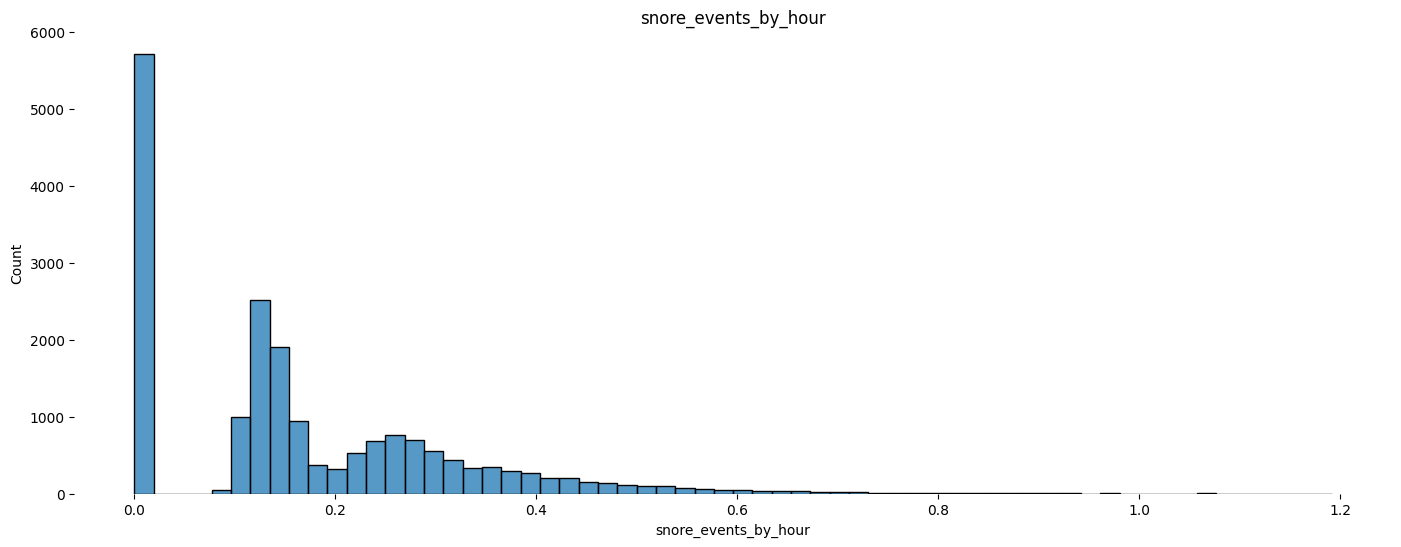

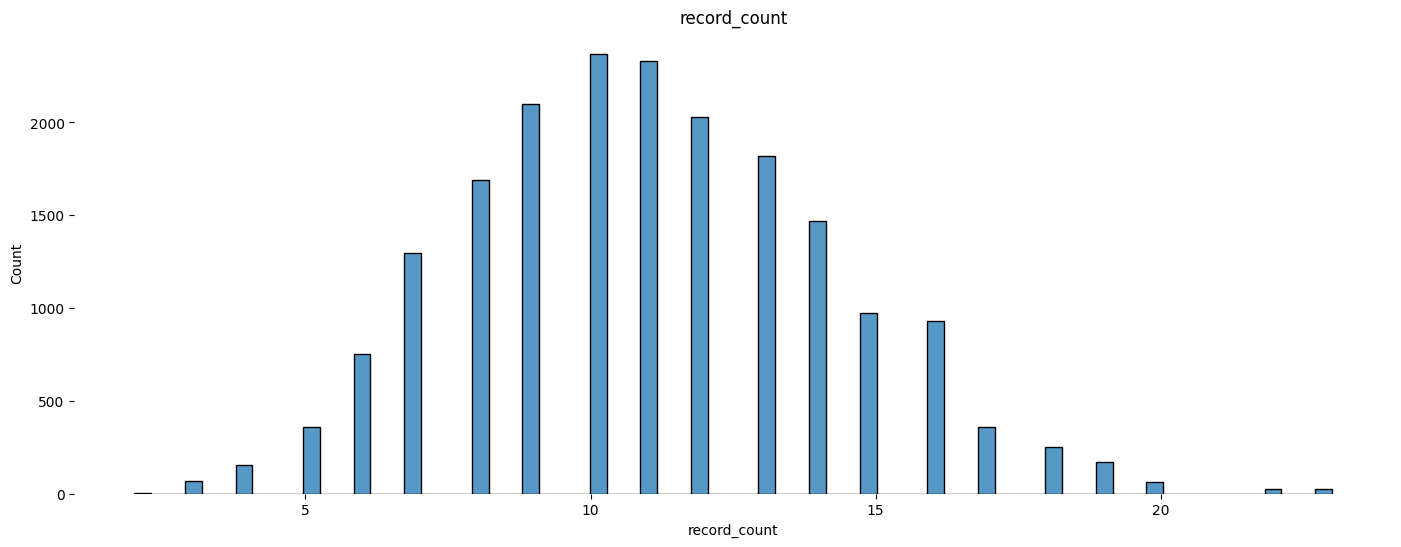

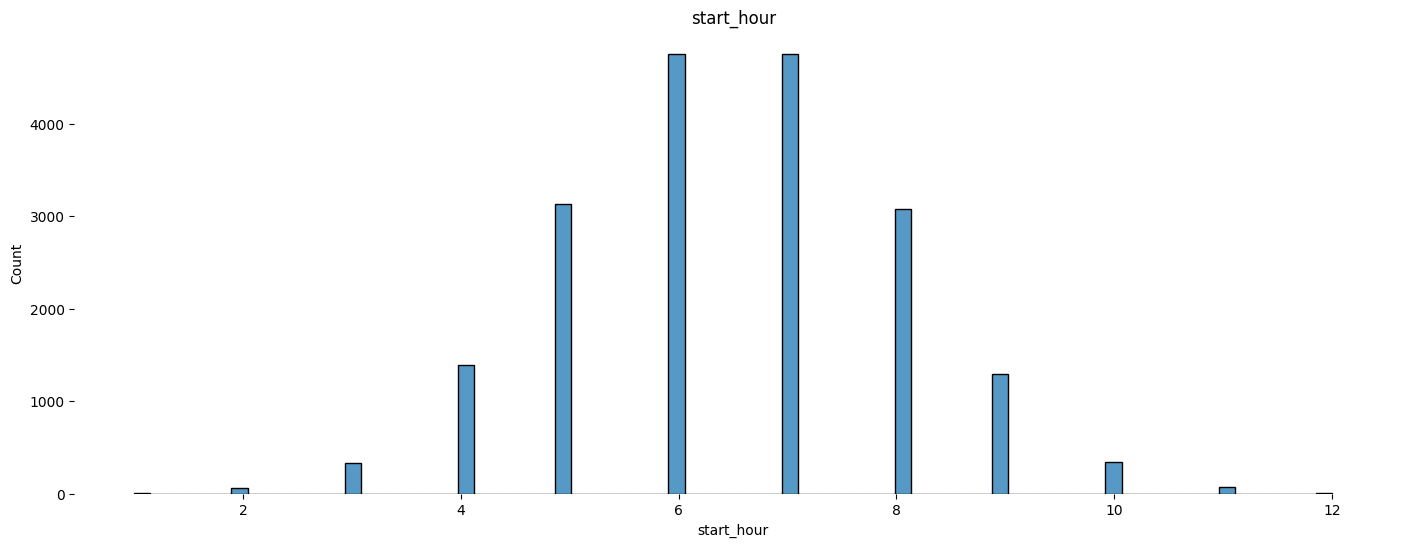

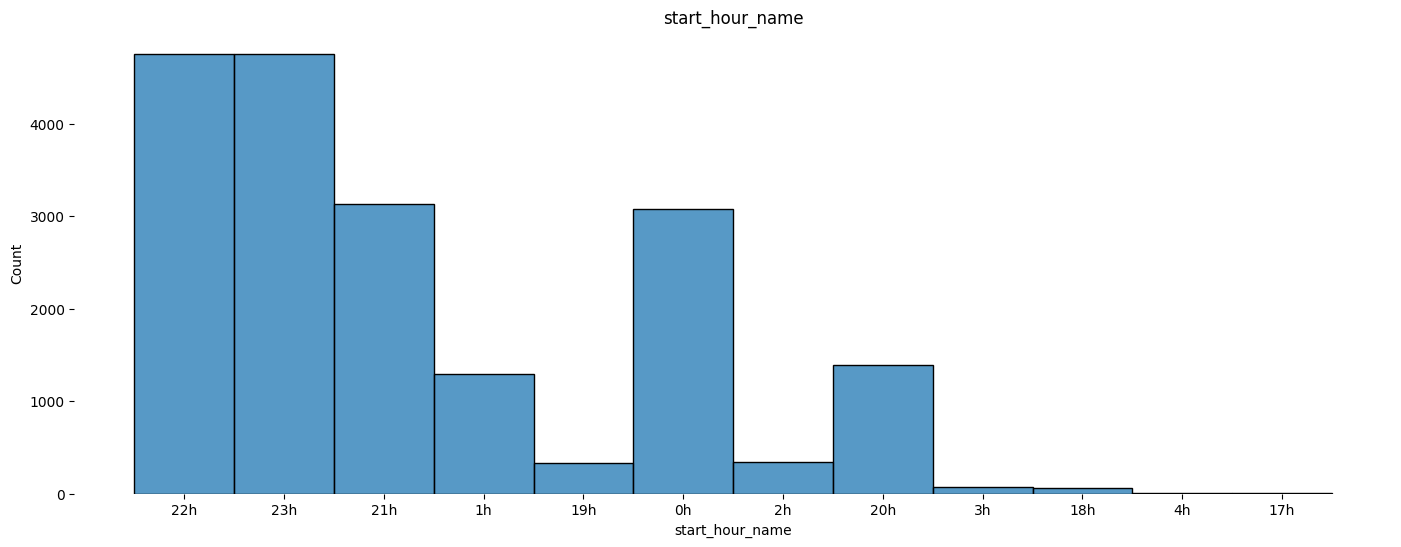

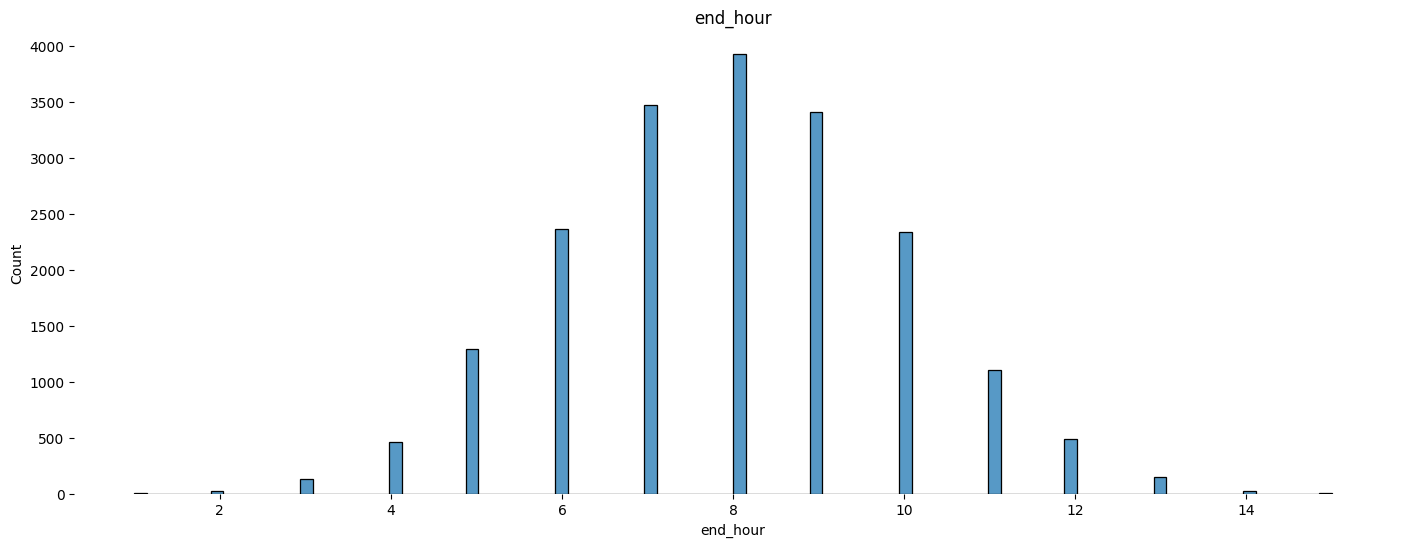

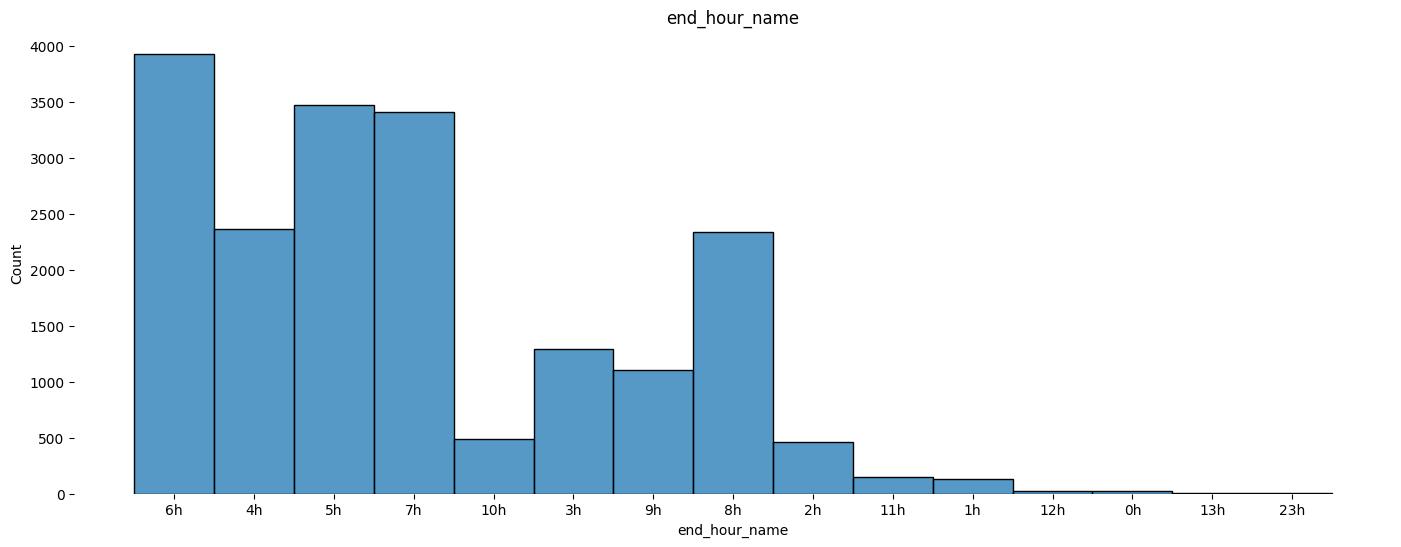

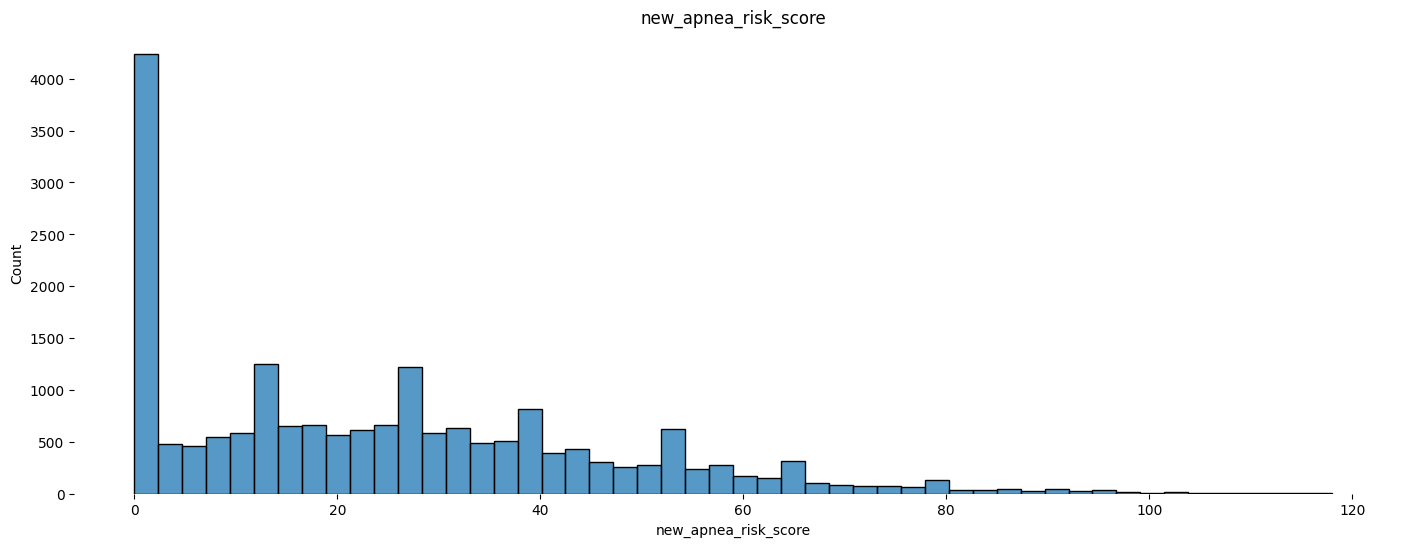

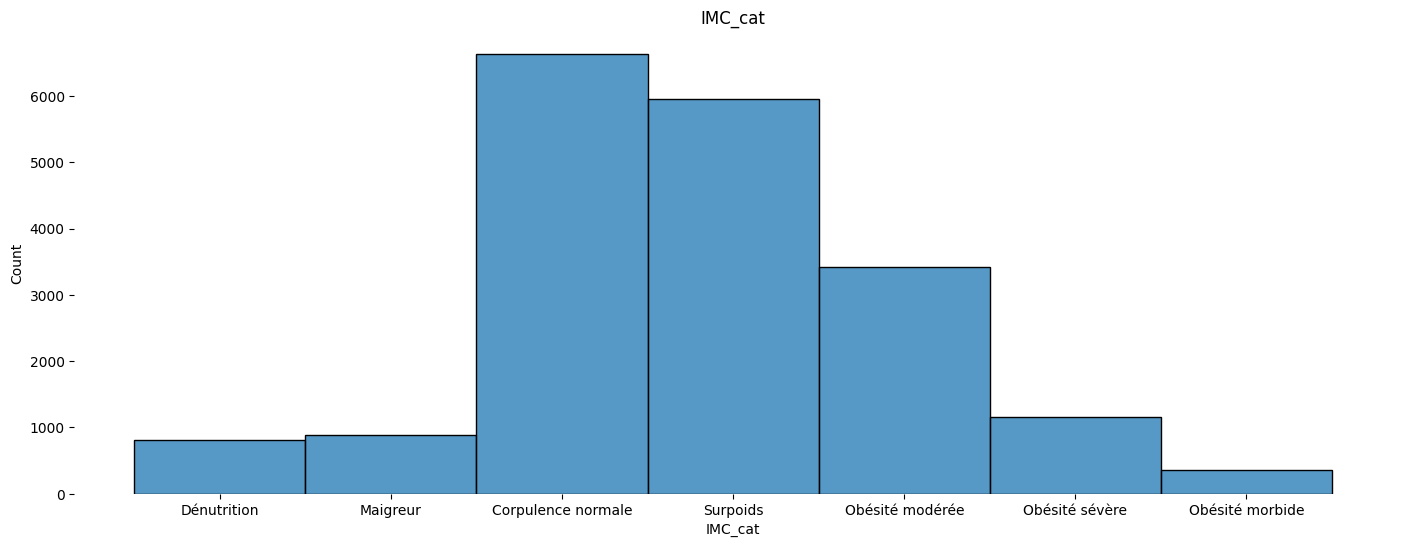

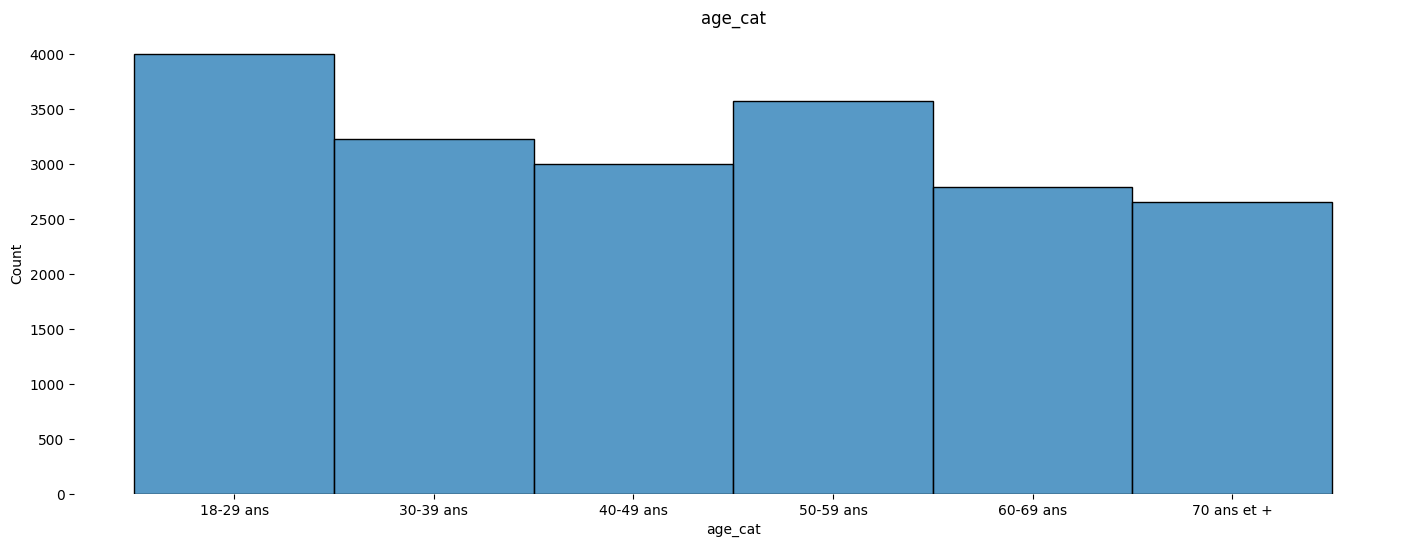

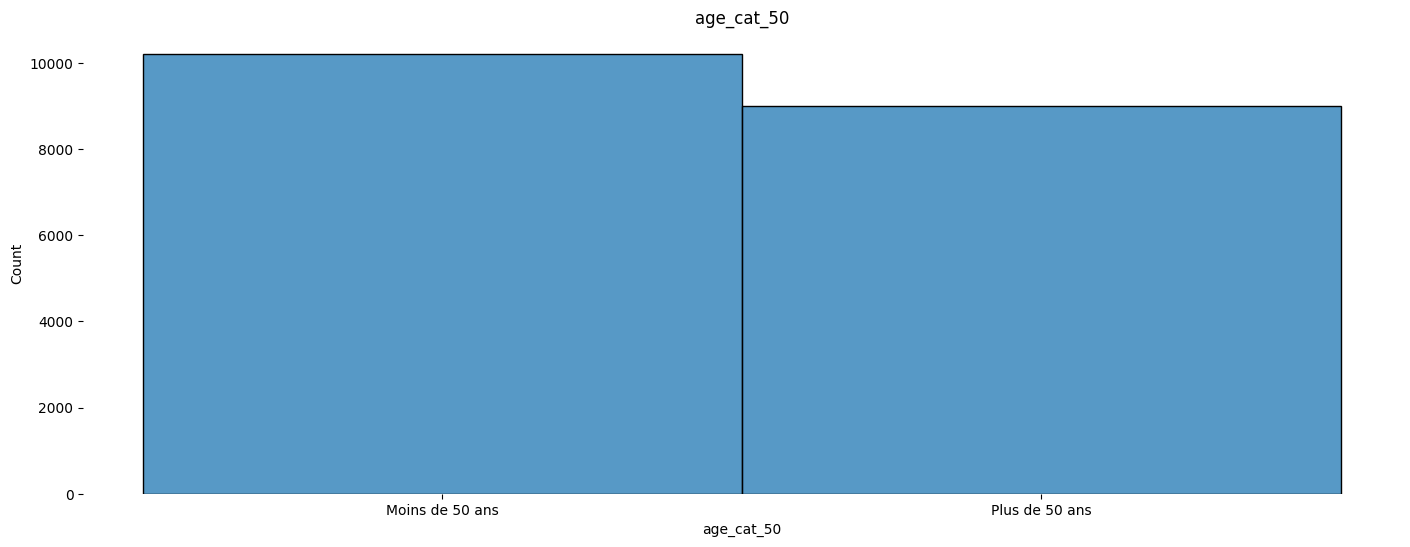

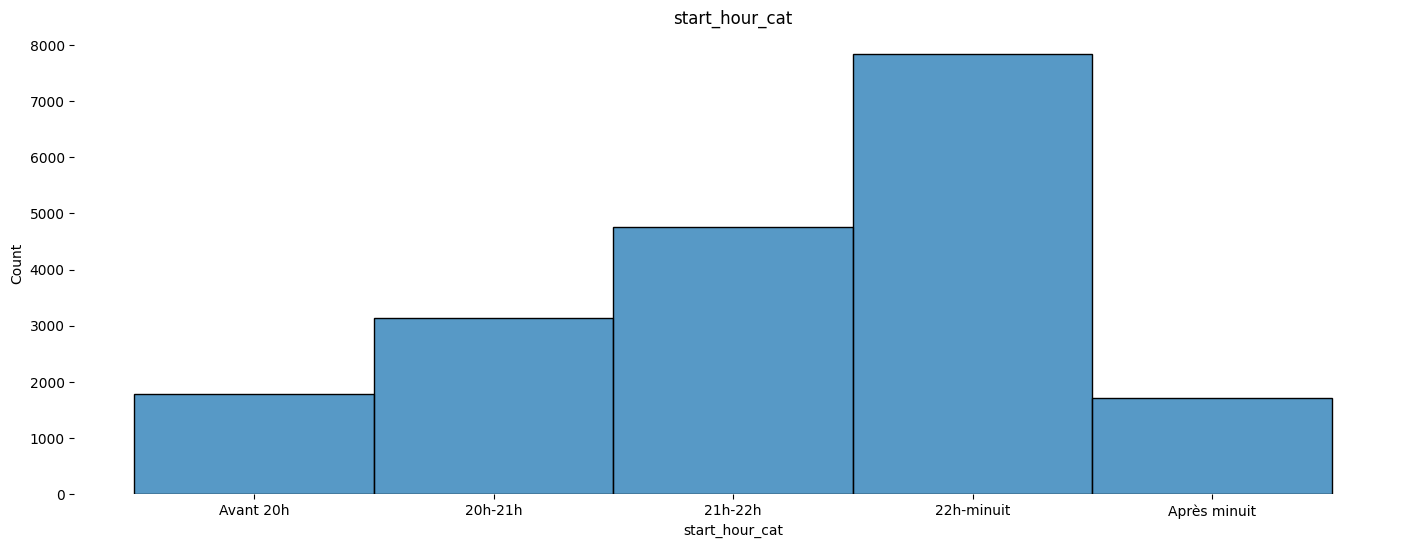

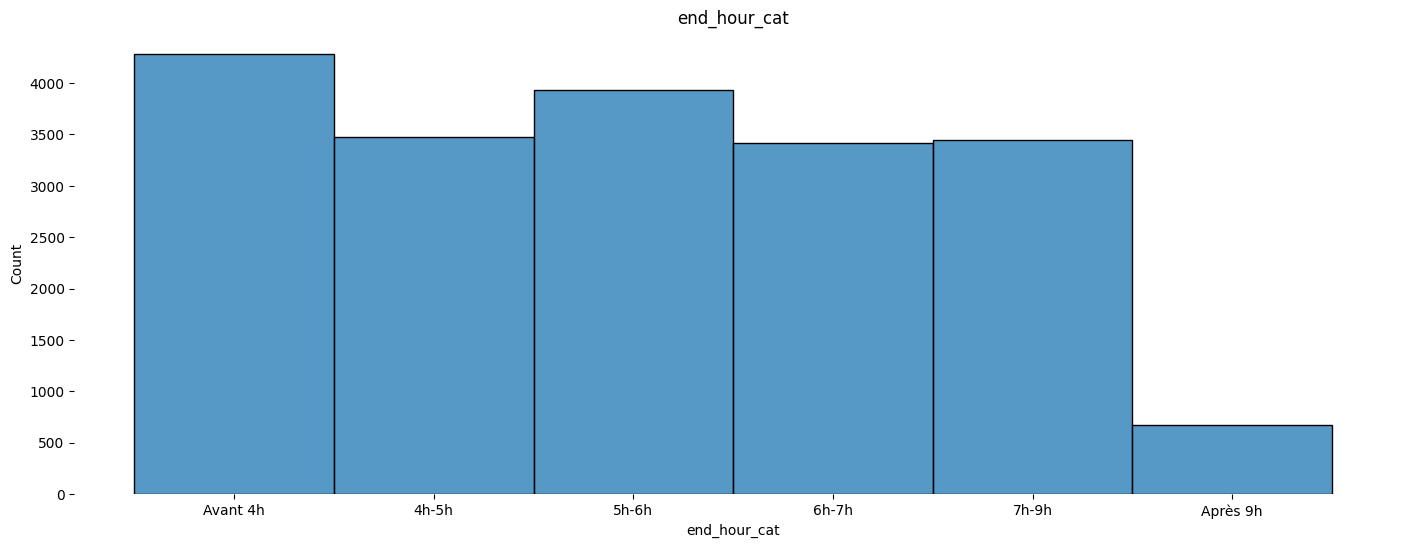

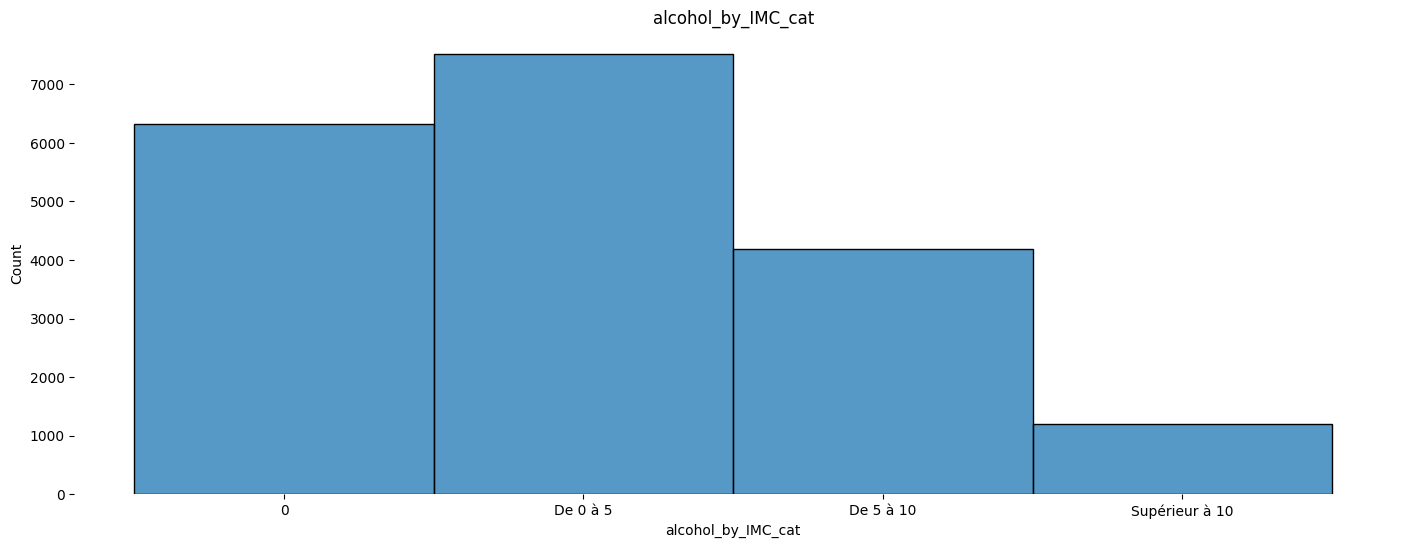

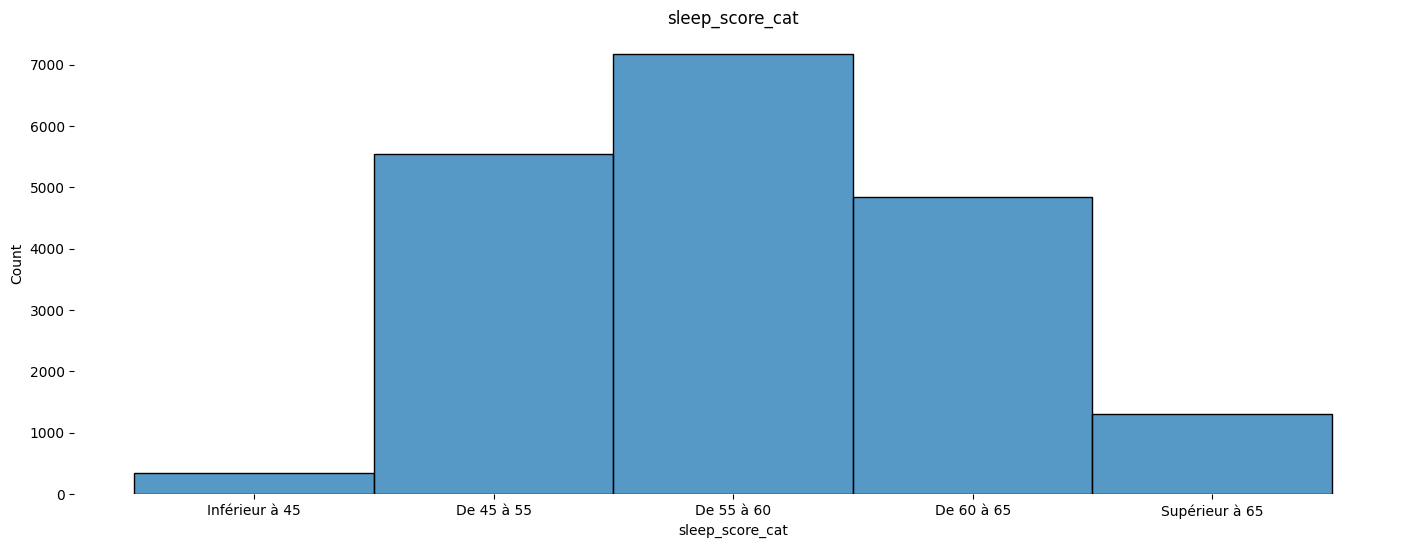

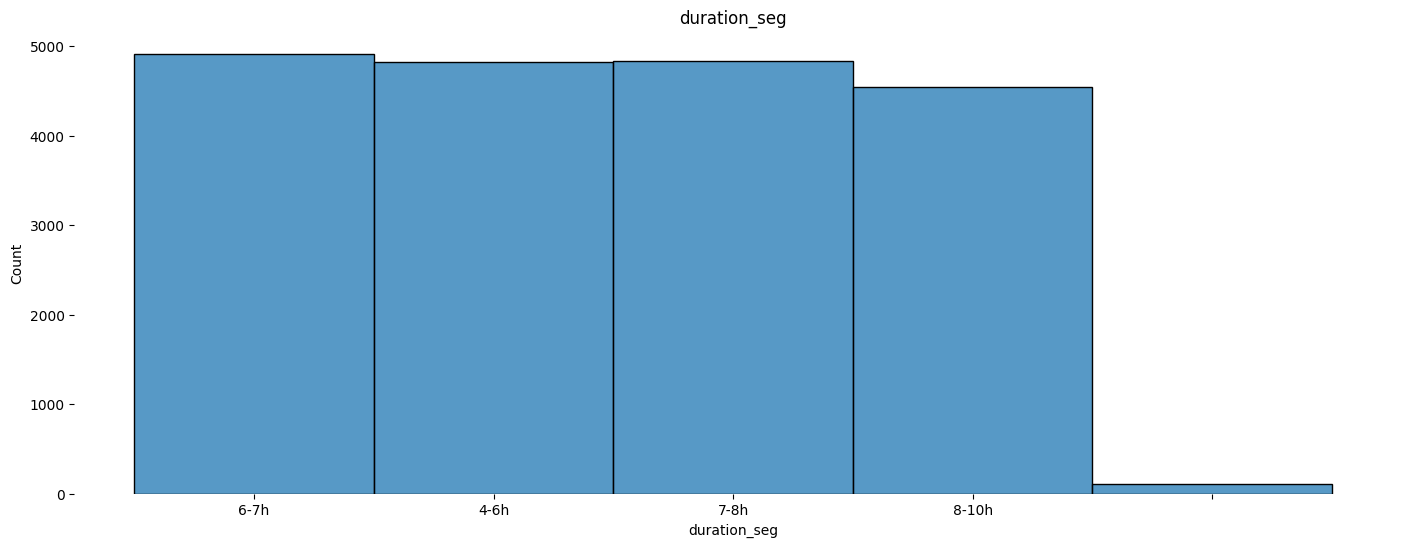

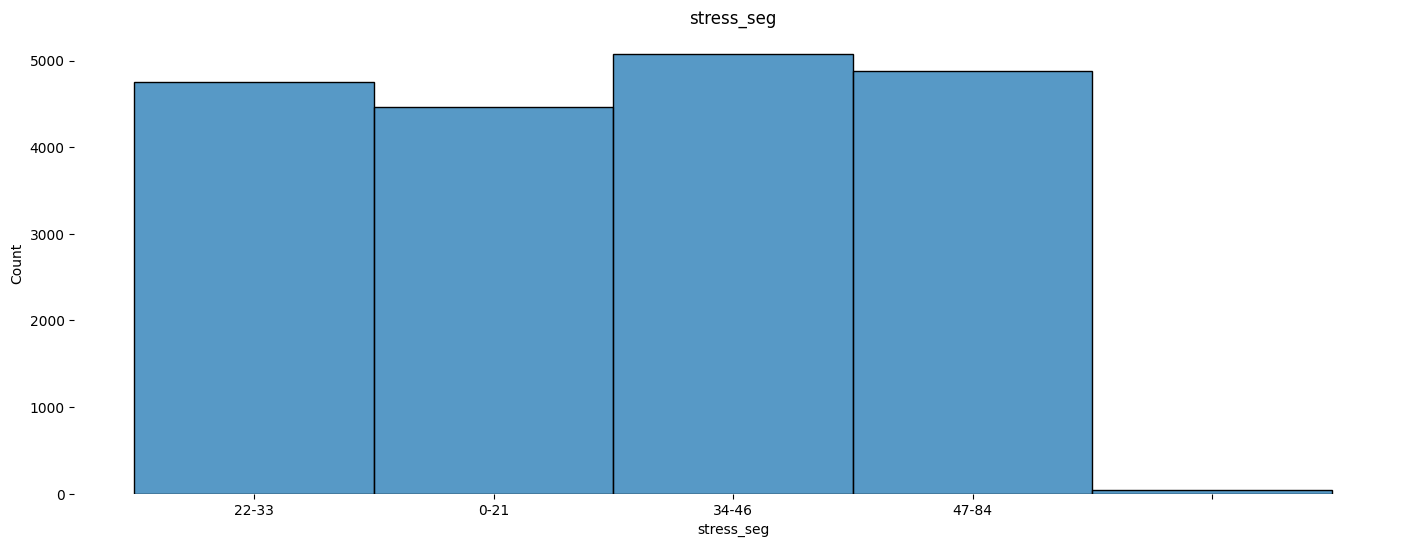

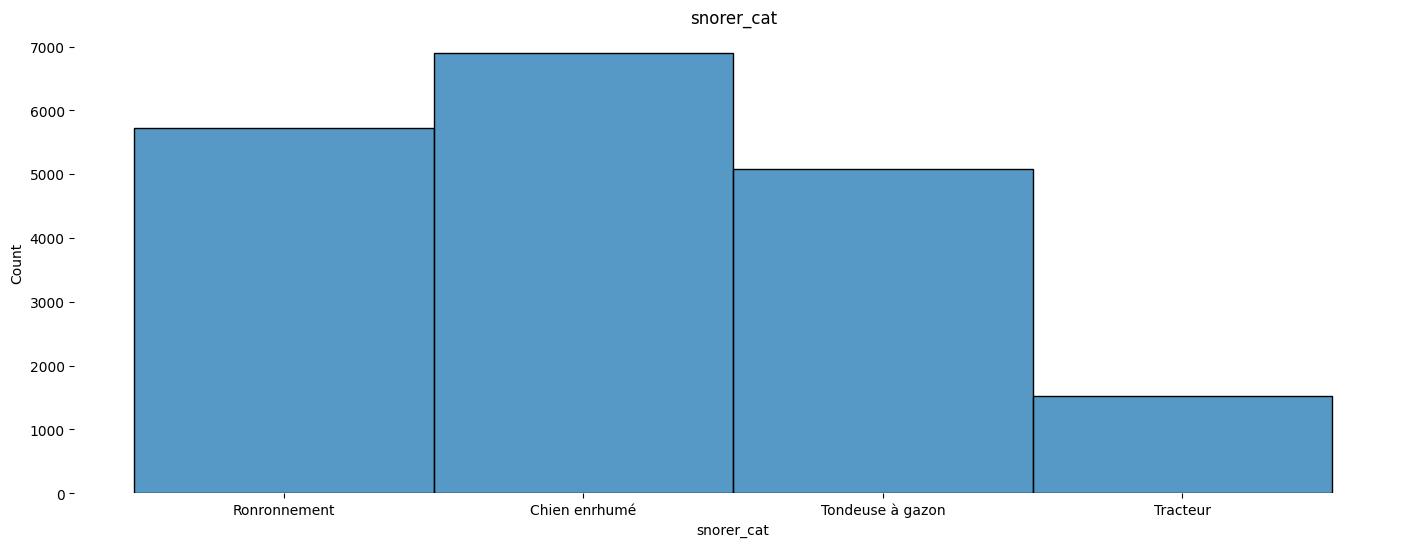

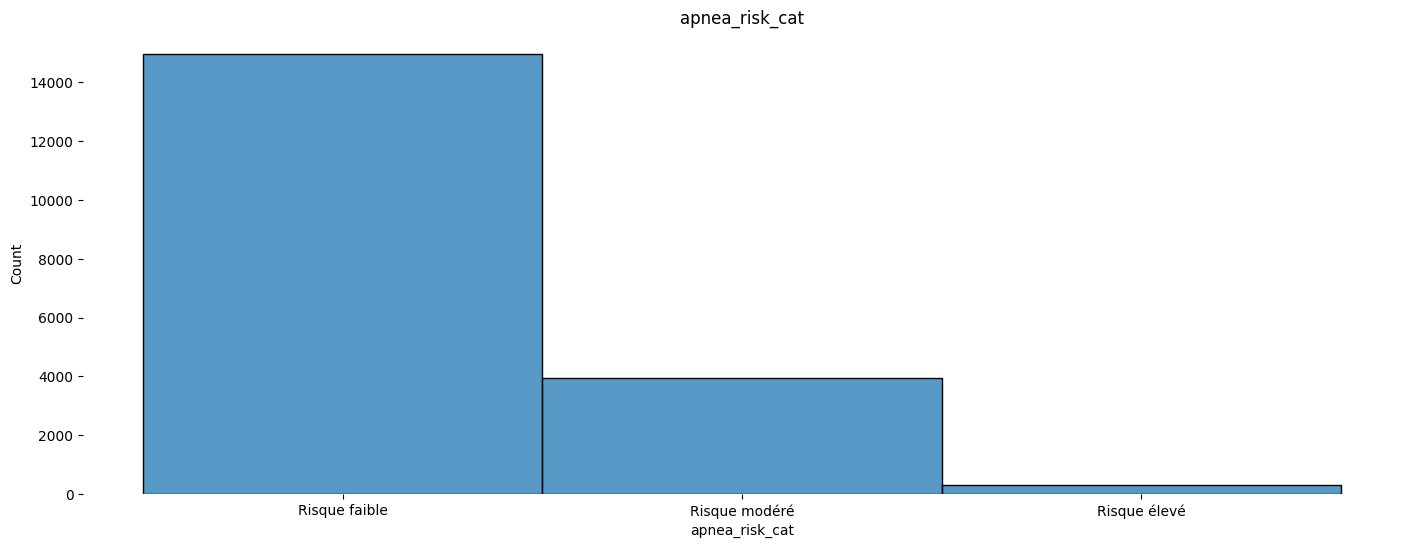

In [17]:
# CREATION DE TOUTES LES BOXPLOT DES FEATURES

for x in df_sleep.columns.tolist() :
  fig, ax = plt.subplots(1,1, figsize=(17,6))
  sns.histplot(df_sleep[x])
  plt.title(x)
  plt.box(False)

In [18]:
# CREATION DE TOUTES LES HEATMAP PAR PARAMETRE ET EXPORT PDF

with PdfPages('/content/drive/MyDrive/Le Wagon/Projet Sommeil/all_features_corr_heatmaps.pdf') as pdf :
  for x in ["pearson","spearman","kendall"] :
    fig, ax = plt.subplots(1,1, figsize=(17,12))
    sns.heatmap(
      df_sleep.select_dtypes(include=number).corr(method=x),
      cmap="coolwarm",
      linewidths=0.5,
      yticklabels=True,
      xticklabels=True,
      )
    plt.title(f"Corrélation de {x}")
    pdf.savefig()
    plt.close()

<Axes: >

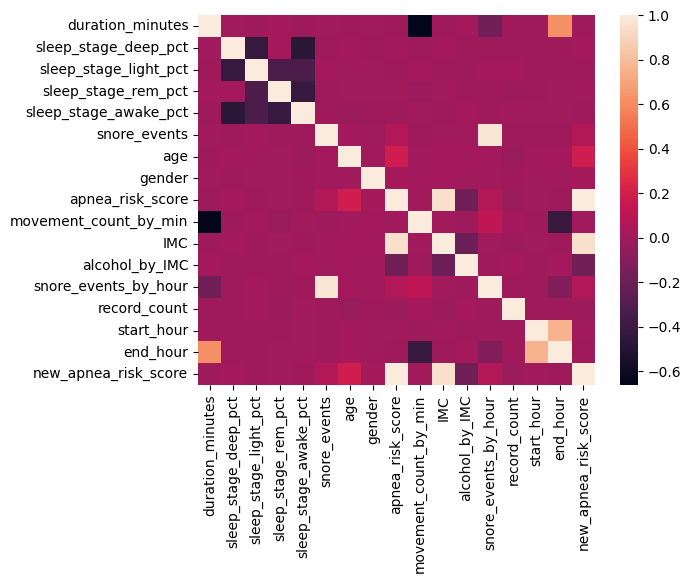

In [19]:
sns.heatmap(
    df_sleep[columns_to_keep].select_dtypes(include=number).corr()
)

<Axes: ylabel='Frequency'>

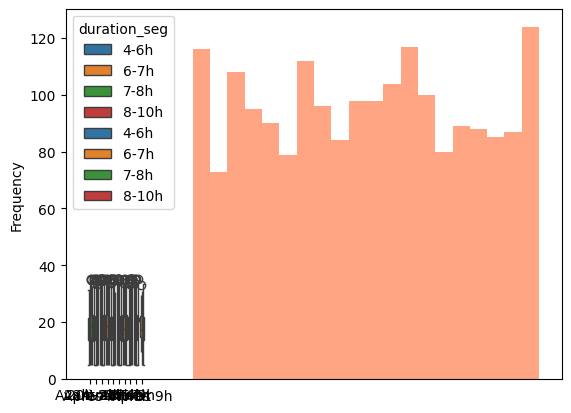

In [20]:
# # BOX PLOT POUR VOIR LES POURCENTAGES DE SOMMEIL PROFOND PAR GENRE ET PAR HEURE DE COUCHER
sns.boxplot(df_sleep, x="start_hour_cat", order=["Avant 20h","20h-21h", "22h-minuit", "Après minuit"], y="sleep_stage_deep_pct", hue="duration_seg", hue_order=["4-6h", "6-7h", "7-8h", "8-10h"])

# # BOX PLOT POUR VOIR LES POURCENTAGES DE SOMMEIL PROFOND PAR GENRE ET PAR HEURE DE LEVER
sns.boxplot(df_sleep, x="end_hour_cat", order=["Avant 4h", "4h-5h", "5h-6h", "6h-7h", "7h-9h", "Après 9h"], y="sleep_stage_deep_pct", hue="duration_seg", hue_order=["4-6h", "6-7h", "7-8h", "8-10h"])

# # HISTOGRAMME POUR VOIR LA REPARTITION DES MOYENNES D'AGE PAR user_id
df_agg = df_sleep.groupby('user_id')['age'].mean()
df_agg.plot.hist(bins=20, color='coral', alpha=0.7)

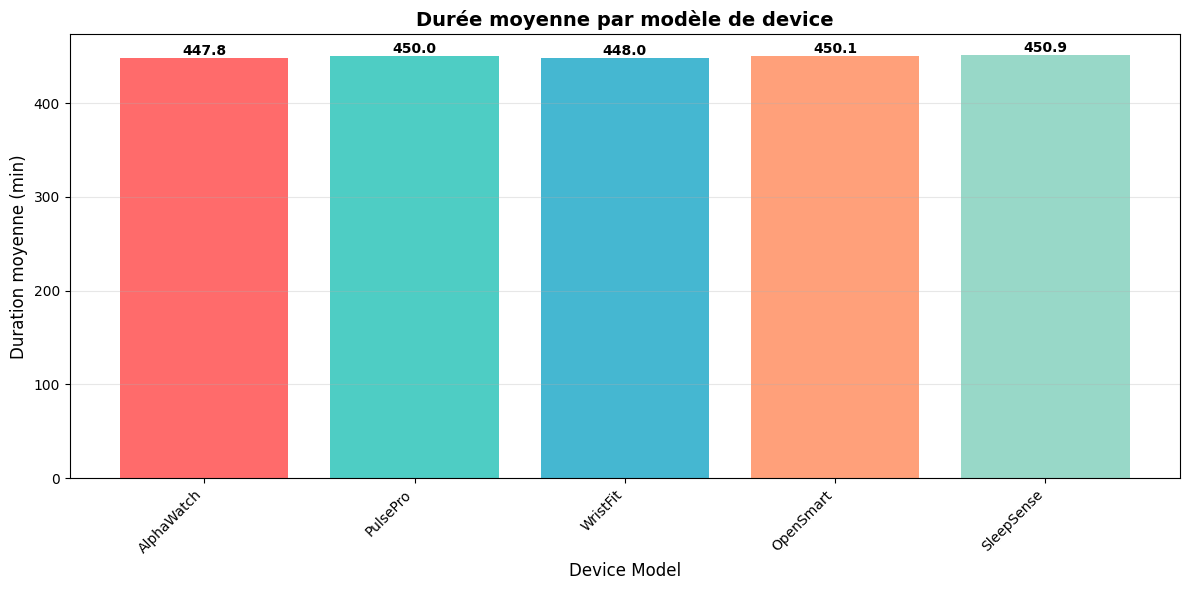

In [21]:
# REPRESENTATION GRAPHIQUE EN BAR DE LA SEGMENTATION DES MODELES DE DEVICES x TEMPS DE SOMMEIL (duration_minutes)

# creation de la colonne device_num pour mapper avec le device model
df_sleep['d_AlphaWatch'] = df_sleep['device_model'].str.contains('AlphaWatch', case=False, na=False).astype(int)
df_sleep['d_PulsePro'] = df_sleep['device_model'].str.contains('PulsePro', case=False, na=False).astype(int)
df_sleep['d_WristFit'] = df_sleep['device_model'].str.contains('WristFit', case=False, na=False).astype(int)
df_sleep['d_OpenSmart'] = df_sleep['device_model'].str.contains('OpenSmart', case=False, na=False).astype(int)
df_sleep['d_SleepSense'] = df_sleep['device_model'].str.contains('SleepSense', case=False, na=False).astype(int)

# Créer les 5 DataFrames filtrés
df_AlphaWatch = df_sleep[df_sleep['d_AlphaWatch'] == 1].copy()
df_PulsePro = df_sleep[df_sleep['d_PulsePro'] == 1].copy()
df_WristFit = df_sleep[df_sleep['d_WristFit'] == 1].copy()
df_OpenSmart = df_sleep[df_sleep['d_OpenSmart'] == 1].copy()
df_SleepSense = df_sleep[df_sleep['d_SleepSense'] == 1].copy()

# Calculer la moyenne de duration_min pour chaque device
moyennes = [
    df_AlphaWatch['duration_minutes'].mean(),
    df_PulsePro['duration_minutes'].mean(),
    df_WristFit['duration_minutes'].mean(),
    df_OpenSmart['duration_minutes'].mean(),
    df_SleepSense['duration_minutes'].mean()
]

devices = ['AlphaWatch', 'PulsePro', 'WristFit', 'OpenSmart', 'SleepSense']

# Créer le bar plot
plt.figure(figsize=(12, 6))
plt.bar(devices, moyennes, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'])
plt.xlabel('Device Model', fontsize=12)
plt.ylabel('Duration moyenne (min)', fontsize=12)
plt.title('Durée moyenne par modèle de device', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, v in enumerate(moyennes):
    plt.text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [22]:
#REPRESENTATION GRAPHIQUE BOXPLOT DE IMC_CATEG x duration_minutes

# Créer le boxplot
ax = sns.boxplot(data=df_sleep, x='IMC_cat', y='duration_minutes', order=IMC_labels)

# Ajouter les médianes sur les boîtes
medians = df_sleep.groupby('IMC_cat')['duration_minutes'].median()
for i, category in enumerate(IMC_labels):
    if category in medians.index:
        ax.text(i, medians[category], f'{medians[category]:.1f}',
                ha='center', va='bottom', fontweight='bold', color='red')

plt.title('Durée en fonction de la catégorie d\'IMC')
plt.xlabel('Catégorie IMC')
plt.ylabel('Durée (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'IMC_labels' is not defined

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(17,6))
fig.suptitle('This is a somewhat long figure title', fontsize=16)
sns.boxplot(
data=df_sleep,
x=df_sleep["IMC_cat"].loc[df_sleep["gender"]==0],
y="apnea_risk_score",
hue=df_sleep["age_cat"],
palette="dark:pink",
ax=ax[0]
)
sns.boxplot(
data=df_sleep,
x=df_sleep["IMC_cat"].loc[df_sleep["gender"]==1],
y="apnea_risk_score",
hue=df_sleep["age_cat"],
palette="dark:blue",
ax=ax[1]
)
plt.title("What is the effect of BMI on risk of apnea ?", color="green",fontsize=10)
plt.xticks(rotation=45)
plt.show()

# MACHINE LEARNING

In [12]:
#Calcul de P-value, unitairement, sans segmentation:

# Variables
target = "sleep_score"
group_var = "IMC"
features = ["age"]
# Sous-table propre
sub = df_sleep[[target, group_var] + features].dropna()
# Encodage du genre si catégoriel
sub[group_var] = sub[group_var].astype("category").cat.codes
# On suppose que apnea_risk_score est déjà numérique
results = []
# 1) Genre vs score d'apnée (Pearson)
r, p = pearsonr(sub[group_var], sub[target])
results.append({"var_x": group_var, "var_y": target, "r": r, "p_val": p})
# 2) Score d'apnée vs âge (Pearson)
r, p = pearsonr(sub[target], sub["age"])
results.append({"var_x": target, "var_y": "age", "r": r, "p_val": p})
results_df = pd.DataFrame(results)
results_df

,var_x,var_y,r,p_val
0,IMC,sleep_score,0.000965,0.893622
1,sleep_score,age,-0.002947,0.682875


In [13]:
df_sleep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19220 entries, 0 to 19999
Data columns (total 66 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   user_id                         19220 non-null  object        
 1   date_recorded                   19220 non-null  datetime64[ns]
 2   sleep_start_timestamp           19220 non-null  datetime64[ns]
 3   sleep_end_timestamp             19220 non-null  datetime64[ns]
 4   duration_minutes                19220 non-null  int64         
 5   sleep_latency_minutes           19220 non-null  int64         
 6   wake_after_sleep_onset_minutes  19220 non-null  int64         
 7   sleep_efficiency_pct            19220 non-null  float64       
 8   sleep_score                     19220 non-null  int64         
 9   daily_label                     19220 non-null  object        
 10  sleep_stage_deep_pct            19220 non-null  float64       
 11  sleep_s

In [14]:
import kagglehub
from os import listdir
from os.path import join, isfile
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import figure
from matplotlib.backends.backend_pdf import PdfPages
import plotly.express as px
import plotly.subplots as psp
import numpy as np
from numpy import number
import seaborn as sns
from scipy.stats import ttest_ind
import statistics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
import shap
from sklearn.metrics import mean_squared_error


# Régression linéaire de l'apnée en fonction des variables pour la présentation (faciles à récolter et qui ont de l'impact)
# @title

X = df_sleep[['weight_kg', 'height_cm',"gender", "age" ]]
y = df_sleep["new_apnea_risk_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=0)

X_train_num = X_train.select_dtypes(include='number')
X_test_num = X_test.select_dtypes(include='number')

scaler = StandardScaler().set_output(transform='pandas')
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Select the non number columns
X_train_cat = X_train.select_dtypes(exclude='number')
X_test_cat = X_test.select_dtypes(exclude='number')

# Instantiate One Hot Encoder
encoder = OneHotEncoder(handle_unknown='warn', sparse_output=False).set_output(transform='pandas')

# Fit and transform
X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

X_train_preproc = pd.concat((X_train_cat_encoded, X_train_num_scaled), axis=1)
X_test_preproc = pd.concat((X_test_cat_encoded, X_test_num_scaled), axis=1)

#train model
lin_reg = LinearRegression()
lin_reg.fit(X_train_preproc, y_train)

# #train model log
# log_reg = LogisticRegression()
# log_reg.fit(X_train_preproc, y_train)

X_new = pd.DataFrame({'weight_kg': [63],'height_cm': [185], 'gender': [1],'age': [70]})
X_new_scaled = scaler.transform(X_new)
predict = lin_reg.predict(X_new_scaled)
print(predict)

single_score = lin_reg.score(X_test_preproc,y_test)
print("score = ",single_score)
cross_score5 = cross_val_score(estimator=lin_reg,X=X_train_preproc,y=y_train,cv=5)
print("cross_score5 = ",cross_score5.mean())
cross_score10=cross_val_score(estimator=lin_reg,X=X_train_preproc,y=y_train,cv=10)
print("cross_score10 = ", cross_score10.mean())

y_pred = lin_reg.predict(X_test_preproc)
mae = mean_absolute_error(y_test, y_pred)
print("mae =", mae)
print("mse = ",mean_squared_error(y_test, y_pred))
print("rmse = ",root_mean_squared_error(y_test,y_pred))
print("variance = ",statistics.variance(df_sleep['new_apnea_risk_score']))

[-0.46398442]
score =  0.886977077495887
cross_score5 =  0.8967357343522918
cross_score10 =  0.8965603165191702
mae = 5.038453107867956
mse =  52.081783626412204
rmse =  7.216770997226682
variance =  476.9703426505346


In [ ]:
# Régression linéaire de l'apnée en fonction des variables pour la présentation (faciles à récolter et qui ont de l'impact)

import xgboost as xgb
from sklearn.linear_model import LogisticRegression

X = df_sleep[['weight_kg', 'height_cm',"gender", "age" ]]
y = df_sleep["apnea_risk_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=0)

X_train_num = X_train.select_dtypes(include='number')
X_test_num = X_test.select_dtypes(include='number')

scaler = StandardScaler().set_output(transform='pandas')
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Select the non number columns
X_train_cat = X_train.select_dtypes(exclude='number')
X_test_cat = X_test.select_dtypes(exclude='number')

# Instantiate One Hot Encoder
encoder = OneHotEncoder(handle_unknown='warn', sparse_output=False).set_output(transform='pandas')

# Fit and transform
X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

X_train_preproc = pd.concat((X_train_cat_encoded, X_train_num_scaled), axis=1)
X_test_preproc = pd.concat((X_test_cat_encoded, X_test_num_scaled), axis=1)

#train model
xboost_reg = LogisticRegression()
xboost_reg.fit(X_train_preproc, y_train)

single_score = xboost_reg.score(X_test_preproc,y_test)
print("score = ",single_score)
# cross_score5 = cross_val_score(estimator=xboost_reg,X=X_train_preproc,y=y_train,cv=5)
# print("cross_score5 = ",cross_score5.mean())
# cross_score10=cross_val_score(estimator=xboost_reg,X=X_train_preproc,y=y_train,cv=10)
# print("cross_score10 = ", cross_score10.mean())

# y_pred = xboost_reg.predict(X_test_preproc)
mae = mean_absolute_error(y_test, y_pred)
print("mae =", mae)
print("mse = ",mean_squared_error(y_test, y_pred))
print("rmse = ",root_mean_squared_error(y_test,y_pred))
print("variance = ",statistics.variance(df_sleep['apnea_risk_score']))
# cross_score5=cross_val_score(estimator=xboost_reg,X=X_train_preproc,y=y_train,cv=5)


X_new = pd.DataFrame({'weight_kg': [65],'height_cm': [175], 'gender': [1], 'age' : [30]})
X_new_scaled = scaler.transform(X_new)
predict = xboost_reg.predict(X_new_scaled)
print("predict =", predict)

In [24]:
predict_list = {"IMC":[],"lin_predict":[]}
for x in list(range(20,200)) :
  X_new = pd.DataFrame({'weight_kg': [x],'height_cm': [170], 'gender': [1],'age': [70]})
  X_new_scaled = scaler.transform(X_new)
  lin_predict = lin_reg.predict(X_new_scaled)[0]
  imc = x/((170/100)**2)
  predict_list["IMC"].append(imc)
  predict_list["lin_predict"].append(lin_predict)
predict_list=pd.DataFrame(predict_list)

px.line(predict_list)

# VIZ

In [25]:
# @title Estimation
# ------------------------------------------------
#    INTERFACE Estimation - VERSION DARK MODE FULL
# ------------------------------------------------
import ipywidgets as widgets
from IPython.display import display, HTML

# Style global (Dark Mode)
display(HTML("""
<style>

    body {background: #0d1117 !important;color: #ffffff !important;}

    /* Wrapper centré */
    .apnea-wrapper {
        display: flex;
        justify-content: center;
        width: 100%;
        margin-top: 50px;
    }

    /* Carte centrale sombre */
    .apnea-container {
        background: #161b22;
        padding: 40px 45px;
        border-radius: 24px;
        width: 540px;
        box-shadow: 0 0 40px rgba(0, 150, 255, 0.12);
        font-family: 'Arial', sans-serif;
        border: 1px solid #1f2937;
        text-align: center;
    }

    .apnea-title {
        color: #58a6ff;
        font-size: 30px;
        margin-bottom: 6px;
        font-weight: bold;
    }

    .apnea-subtitle {
        color: #9baecf;
        font-size: 15px;
        margin-bottom: 25px;
        text-align: center;
    }

    /* Résultat stylé */
    .apnea-result {
        background: #1f2937;
        padding: 20px;
        border-left: 6px solid #3B82F6;
        border-radius: 12px;
        margin-top: 22px;
        box-shadow: 0 0 12px rgba(59,130,246,0.25);
        text-align: left;
    }

    .apnea-result h3 {
        margin: 0;
        color: #93c5fd;
        font-size: 20px;
    }

    .apnea-result p {
        margin: 10px 0 0 0;
        font-size: 20px;
        color: #ffffff;
        font-weight: bold;
    }

    /******************************************************
     *      STYLE DES CHAMPS SOMBRES (FORCÉ POUR COLAB)
     ******************************************************/
    .widget-text input,
    .widget-number input,
    .widget-dropdown select {
        background-color: #0d1117 !important;
        color: #ffffff !important;
        border: 1px solid #30363d !important;
        border-radius: 14px !important;
        padding: 10px !important;
        height: 38px !important;
        font-size: 15px;
        font-weight: bold;
    }

    .widget-dropdown select {
        padding-left: 6px !important;
    }

    /* Bouton bleu néon */
    .widget-button {
        background-color: #2385ff !important;
        color: white !important;
        border-radius: 16px !important;
        font-weight: bold !important;
        border: none !important;
        height: 48px !important;
        font-size: 17px !important;
        transition: 0.25s;
        box-shadow: 0 0 14px rgba(35,133,255,0.45);
    }


    .widget-button:hover {
        background-color: #1a66d1 !important;
        transform: scale(1.04);
        box-shadow: 0 0 20px rgba(35,133,255,0.6);
    }

/* Supprime les flèches ↑↓ des champs numériques */
input[type=number]::-webkit-inner-spin-button,
input[type=number]::-webkit-outer-spin-button {
    -webkit-appearance: none !important;
    margin: 0 !important;
}

input[type=number] {
    -moz-appearance: textfield !important;
}


</style>
"""))

# ---- Structure visuelle ----
display(HTML("""
<div class='apnea-wrapper'>
    <div class='apnea-container'>
        <div class='apnea-title'>🌙 Estimation du score d'apnée</div>
        <div id='apnea-form'></div>
    </div>
</div>
"""))

# ---------- Widgets ----------
weight_input = widgets.FloatText(description='Poids (kg):', value=70, layout=widgets.Layout(width='90%',margin="20px auto 0 auto",
        border='none', border_radius='12px'))
height_input = widgets.FloatText(description='Taille (cm):', value=175, layout=widgets.Layout(width='90%',margin="20px auto 0 auto",
        border='none', border_radius='12px'))
age_input = widgets.IntText(description='Âge :', value=40, layout=widgets.Layout(width='90%',margin="20px auto 0 auto",
        border='none', border_radius='12px'))
gender_input = widgets.Dropdown(description='Genre :', options=[('Homme', 1), ('Femme', 0)], value=1, layout=widgets.Layout(width='90%',margin="20px auto 0 auto",
        border='none', border_radius='12px'))

button = widgets.Button(
    description="🔮 estimer le score 🔮",
    layout=widgets.Layout(
        width='90%',
        margin="20px auto 0 auto",   # ← auto = centré dans SON PROPRE ESPACE
        border='none',
        border_radius='12px'
        ))

prediction_output = widgets.Output()

# ---------- Fonction de prédiction ----------
def on_button_clicked(b):
    prediction_output.clear_output()
    with prediction_output:

        # --- Calcul de la prédiction ---
        X_live = pd.DataFrame({
            "weight_kg": [weight_input.value],
            "height_cm": [height_input.value],
            "gender": [gender_input.value],
            "age": [age_input.value]
        })

        X_live_scaled = scaler.transform(X_live)
        prediction = round(lin_reg.predict(X_live_scaled)[0])

        # --- Bornes ---
        IMC = ([weight_input.value]/(([height_input.value]/100)**2))
        prediction = max(0, min(prediction, 100))

        # --- Couleur + Texte de risque ---
        if prediction <= 25:
            color = "#22c55e"     # vert
            risk_label = "Risque faible"
        elif prediction <= 50:
            color = "#ff7f00"     # orange
            risk_label = "Risque modéré"
        else:
            color = "#ef4444"     # rouge
            risk_label = "Risque élevé"

        # --- Affichage ---
        display(HTML(f"""
        <div class='apnea-result' style='border-left: 6px solid {color};'>
            <h3>Résultat :</h3>
            <p>IMC :
                <span style='color:{color}; font-weight:bold;'>{IMC:.2f}</span>
            </p>
            <p>Score d'apnée estimé :
                <span style='color:{color}; font-weight:bold;'>{prediction:.2f}</span>
            </p>
            <p style='color:{color}; font-size:18px; margin-top:8px;'>
                {risk_label}
            </p>
        </div>
        """))



button.on_click(on_button_clicked)

# --------- Ajout des widgets DANS la carte ---------
form_box = widgets.VBox([
    weight_input,
    height_input,
    age_input,
    gender_input,
    button,
    prediction_output
])

display(form_box)


In [31]:
# version 2 finale que nous avons utilisé
# car sela créé un site provisoire utilisable dans looker.

!pip install gradio

import gradio as gr

# import joblib

# --------------------------------------------------
# Charger ton modèle
# --------------------------------------------------
# lin_reg = joblib.load("lin_reg.pkl")
# scaler = joblib.load("scaler.pkl")

# --------------------------------------------------
# Fonction prédiction
# --------------------------------------------------
def predict_apnea(weight, height, age, gender):

    X_live = pd.DataFrame({
        "weight_kg": [weight],
        "height_cm": [height],
        "gender": [gender],
        "age": [age]
    })

    X_live_scaled = scaler.transform(X_live)
    prediction =round(lin_reg.predict(X_live_scaled)[0],0)

    prediction = max(0, min(prediction, 100))

    # Couleur + label
    if prediction <= 25:
        color = "#22c55e"
        font_weight= "bold"
        risk_label = "Risque faible"
    elif prediction <= 50:
        color = "#ff7f00"
        font_weight= "bold"
        risk_label = "Risque modéré"
    else:
        color = "#ef4444"
        font_weight= "bold"
        risk_label = "Risque élevé"

    IMC = float(X_live["weight_kg"].iloc[0] / ((X_live["height_cm"].iloc[0] / 100) ** 2))

    if IMC < 16.5:
        IMC_cat = "Dénutrition"
    elif IMC < 18.5:
        IMC_cat = "Maigreur"
    elif IMC < 25:
        IMC_cat = "Corpulence normale"
    elif IMC < 30:
        IMC_cat = "Surpoids"
    elif IMC < 35:
        IMC_cat = "Obésité modérée"
    elif IMC < 40:
        IMC_cat = "Obésité sévère"
    else:
        IMC_cat = "Obésité morbide"

    # -------- CORRECTION : indentation réparée ici --------
    html = f"""
<div style="
    background:#1f2937;
    padding:20px;
    border-radius:16px;
    border-left:6px solid {color};
    color:white;
    box-shadow:0 0 20px rgba(59,130,246,0.20);
    font-family:Arial;
">
    <h3 style="color:#93c5fd;font-size:22px;margin:0;">Résultat :</h3>

    <div style="display:flex;gap:20px;align-items:flex-start;margin-top:15px;">

        <!-- Bloc principal -->
        <div style="flex:1;">
            <p style="font-size:16px;margin-top:10px;">
                IMC :
                <span style="color:#FFFFFF;">{IMC_cat}</span>
            </p>

            <p style="font-size:20px;margin-top:10px;">
                Score d'apnée estimé :
                <span style="color:{color};font-weight:bold;">{prediction:.0f}</span>
            </p>

            <p style="font-size:18px;color:{color};font-weight:bold;margin-top:5px;">
                {risk_label}
            </p>
        </div>

        <!-- Bloc échelle -->
        <div style="
            width:180px;
            background:#111826;
            border-radius:12px;
            padding:12px;
            border:1px solid #374151;
        ">
            <h4 style="margin:0 0 10px 0;color:#9ca3af;font-size:16px;text-align:center;">
                Échelle du score
            </h4>

            <div style="display:flex;flex-direction:column;gap:8px;font-size:14px;">

                <div style="display:flex;align-items:center;gap:10px;">
                    <div style="
                        width:18px;height:18px;
                        background:#22c55e;
                        border-radius:4px;
                    "></div>
                    <span>0 - 25 : Faible</span>
                </div>

                <div style="display:flex;align-items:center;gap:10px;">
                    <div style="
                        width:18px;height:18px;
                        background:#ff7f00;
                        border-radius:4px;
                    "></div>
                    <span>26 - 50 : Modéré</span>
                </div>

                <div style="display:flex;align-items:center;gap:10px;">
                    <div style="
                        width:18px;height:18px;
                        background:#ef4444;
                        border-radius:4px;
                    "></div>
                    <span>51 - 100 : Élevé</span>
                </div>

            </div>
        </div>
    </div>
</div>
"""
    return html

    # ------------------------------------------------------


# --------------------------------------------------
# CSS COMPLETEMENT PERSONNALISÉ
# --------------------------------------------------
custom_css = """
/* Conteneur global */
body, .gradio-container {
    background: #0d1117 !important;
}

/* Champs */
input, select, .gr-input {
    background:#0d1117 !important;
    color:white !important;
    border:1px solid #30363d !important;
    border-radius:14px !important;
    font-size:16px !important;
    padding:10px !important;
}

/* Labels */
label, .gr-label {
    color:#9baecf !important;
    font-weight:bold !important;
}

/* Bouton */
button {
    background:#2385ff !important;
    color:white !important;
    border-radius:14px !important;
    font-size:17px !important;
    height:48px !important;
    font-weight:bold !important;
    border:none !important;
    box-shadow:0 0 14px rgba(35,133,255,0.45);
    transition:0.25s;
}

.container.svelte-1hfxrpf .wrap.svelte-1hfxrpf {
  border:none;
  padding:0;
}

button:hover {
    background:#1a66d1 !important;
    transform:scale(1.04);
    box-shadow:0 0 20px rgba(35,133,255,0.6);
}

/* Retirer les spinners numériques */
input[type=number]::-webkit-inner-spin-button,
input[type=number]::-webkit-outer-spin-button {
    -webkit-appearance: none !important;
    margin: 0 !important;
}

input[type=number] {
    -moz-appearance: textfield !important;
}
"""

# --------------------------------------------------
# Interface Gradio
# --------------------------------------------------
with gr.Blocks(css=custom_css) as demo:

    gr.Markdown("""
    <h1 style='text-align:center;color:#58a6ff;'>🌙 Estimation du score de risque d'apnée du sommeil</h1>
    <p style='text-align:center;color:#9baecf;font-size:16px;'>
        Interface Dark Mode Premium
    </p>
    """)

    with gr.Column(scale=1):
        with gr.Row():
            weight = gr.Number(label="Poids (kg)", value=95)
            height = gr.Number(label="Taille (cm)", value=170)

        with gr.Row():
            age = gr.Number(label="Âge", value=65)
            gender = gr.Dropdown(label="Genre", choices=["Homme","Femme"], value="Homme")

        btn = gr.Button("🔮 Estimer le score 🔮")
        output = gr.HTML()

    def wrapper(weight, height, age, gender):
        gender_value = 1 if gender == "Homme" else 0
        return predict_apnea(weight, height, age, gender_value)

    btn.click(wrapper, inputs=[weight, height, age, gender], outputs=output)

demo.launch()

/tmp/ipython-input-3126643668.py:215: DeprecationWarning:

The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.



It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0e45dacc9350cac7c5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
